In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b10_b25_b50_b75_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 856)
(1079604, 3)
validation
(190293, 856)
(190293, 3)
test
(137379, 856)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 856)]             0         


 dense (Dense)               (None, 1024)              877568    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1566979 (5.98 MB)


Trainable params: 1566979 (5.98 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:05 - loss: 1.2784 - STD: 0.2033 - MAE: 0.4459

  2/108 [..............................] - ETA: 1:07 - loss: 1.1869 - STD: 0.1070 - MAE: 0.4451

  6/108 [>.............................] - ETA: 14s - loss: 1.1645 - STD: 0.1008 - MAE: 0.4448 

 10/108 [=>............................] - ETA: 8s - loss: 1.1420 - STD: 0.0780 - MAE: 0.4446 

 13/108 [==>...........................] - ETA: 6s - loss: 1.1368 - STD: 0.0766 - MAE: 0.4445

 16/108 [===>..........................] - ETA: 5s - loss: 1.1300 - STD: 0.0659 - MAE: 0.4445

 19/108 [====>.........................] - ETA: 4s - loss: 1.1260 - STD: 0.0618 - MAE: 0.4444

 22/108 [=====>........................] - ETA: 4s - loss: 1.1228 - STD: 0.0582 - MAE: 0.4443

 25/108 [=====>........................] - ETA: 3s - loss: 1.1198 - STD: 0.0528 - MAE: 0.4443

 28/108 [======>.......................] - ETA: 3s - loss: 1.1176 - STD: 0.0496 - MAE: 0.4443

 31/108 [=======>......................] - ETA: 2s - loss: 1.1156 - STD: 0.0465 - MAE: 0.4442

 34/108 [========>.....................] - ETA: 2s - loss: 1.1139 - STD: 0.0430 - MAE: 0.4442

 37/108 [=========>....................] - ETA: 2s - loss: 1.1123 - STD: 0.0407 - MAE: 0.4441

 40/108 [==========>...................] - ETA: 2s - loss: 1.1109 - STD: 0.0385 - MAE: 0.4441

 43/108 [==========>...................] - ETA: 2s - loss: 1.1095 - STD: 0.0366 - MAE: 0.4439

 46/108 [===========>..................] - ETA: 1s - loss: 1.1079 - STD: 0.0354 - MAE: 0.4438

 49/108 [============>.................] - ETA: 1s - loss: 1.1063 - STD: 0.0345 - MAE: 0.4435

 52/108 [=============>................] - ETA: 1s - loss: 1.1043 - STD: 0.0341 - MAE: 0.4432

 55/108 [==============>...............] - ETA: 1s - loss: 1.1017 - STD: 0.0346 - MAE: 0.4426

 58/108 [===============>..............] - ETA: 1s - loss: 1.0984 - STD: 0.0362 - MAE: 0.4418

 61/108 [===============>..............] - ETA: 1s - loss: 1.0943 - STD: 0.0391 - MAE: 0.4405

 64/108 [================>.............] - ETA: 1s - loss: 1.0898 - STD: 0.0432 - MAE: 0.4388

 67/108 [=================>............] - ETA: 1s - loss: 1.0852 - STD: 0.0478 - MAE: 0.4370

 70/108 [==================>...........] - ETA: 1s - loss: 1.0802 - STD: 0.0525 - MAE: 0.4350

 73/108 [===================>..........] - ETA: 0s - loss: 1.0750 - STD: 0.0568 - MAE: 0.4331

 76/108 [====================>.........] - ETA: 0s - loss: 1.0696 - STD: 0.0609 - MAE: 0.4311

 79/108 [====================>.........] - ETA: 0s - loss: 1.0642 - STD: 0.0647 - MAE: 0.4292

 82/108 [=====================>........] - ETA: 0s - loss: 1.0586 - STD: 0.0685 - MAE: 0.4272

 85/108 [======================>.......] - ETA: 0s - loss: 1.0533 - STD: 0.0724 - MAE: 0.4252

 89/108 [=======================>......] - ETA: 0s - loss: 1.0464 - STD: 0.0774 - MAE: 0.4226

 93/108 [========================>.....] - ETA: 0s - loss: 1.0397 - STD: 0.0824 - MAE: 0.4199

 97/108 [=========================>....] - ETA: 0s - loss: 1.0335 - STD: 0.0870 - MAE: 0.4174

101/108 [===========================>..] - ETA: 0s - loss: 1.0274 - STD: 0.0915 - MAE: 0.4150

105/108 [============================>.] - ETA: 0s - loss: 1.0214 - STD: 0.0959 - MAE: 0.4125

108/108 [==============================] - 5s 32ms/step - loss: 1.0173 - STD: 0.0991 - MAE: 0.4108 - val_loss: 0.8616 - val_STD: 0.2189 - val_MAE: 0.3423


Epoch 2/10000


  1/108 [..............................] - ETA: 4s - loss: 0.8477 - STD: 0.2161 - MAE: 0.3425

  4/108 [>.............................] - ETA: 1s - loss: 0.8555 - STD: 0.2136 - MAE: 0.3451

  7/108 [>.............................] - ETA: 1s - loss: 0.8556 - STD: 0.2148 - MAE: 0.3448

 10/108 [=>............................] - ETA: 1s - loss: 0.8559 - STD: 0.2161 - MAE: 0.3443

 13/108 [==>...........................] - ETA: 1s - loss: 0.8542 - STD: 0.2174 - MAE: 0.3434

 16/108 [===>..........................] - ETA: 1s - loss: 0.8541 - STD: 0.2186 - MAE: 0.3429

 19/108 [====>.........................] - ETA: 1s - loss: 0.8520 - STD: 0.2196 - MAE: 0.3420

 22/108 [=====>........................] - ETA: 1s - loss: 0.8514 - STD: 0.2206 - MAE: 0.3415

 25/108 [=====>........................] - ETA: 1s - loss: 0.8504 - STD: 0.2216 - MAE: 0.3408

 28/108 [======>.......................] - ETA: 1s - loss: 0.8495 - STD: 0.2222 - MAE: 0.3404

 31/108 [=======>......................] - ETA: 1s - loss: 0.8484 - STD: 0.2230 - MAE: 0.3398

 35/108 [========>.....................] - ETA: 1s - loss: 0.8475 - STD: 0.2238 - MAE: 0.3392

 38/108 [=========>....................] - ETA: 1s - loss: 0.8465 - STD: 0.2246 - MAE: 0.3387

 41/108 [==========>...................] - ETA: 1s - loss: 0.8456 - STD: 0.2252 - MAE: 0.3382

 44/108 [===========>..................] - ETA: 1s - loss: 0.8455 - STD: 0.2255 - MAE: 0.3381

 47/108 [============>.................] - ETA: 1s - loss: 0.8444 - STD: 0.2261 - MAE: 0.3376

 50/108 [============>.................] - ETA: 1s - loss: 0.8440 - STD: 0.2269 - MAE: 0.3371

 53/108 [=============>................] - ETA: 1s - loss: 0.8430 - STD: 0.2274 - MAE: 0.3367

 56/108 [==============>...............] - ETA: 0s - loss: 0.8421 - STD: 0.2279 - MAE: 0.3362

 59/108 [===============>..............] - ETA: 0s - loss: 0.8413 - STD: 0.2285 - MAE: 0.3358

 62/108 [================>.............] - ETA: 0s - loss: 0.8405 - STD: 0.2290 - MAE: 0.3354

 65/108 [=================>............] - ETA: 0s - loss: 0.8396 - STD: 0.2296 - MAE: 0.3350

 68/108 [=================>............] - ETA: 0s - loss: 0.8385 - STD: 0.2301 - MAE: 0.3345

 71/108 [==================>...........] - ETA: 0s - loss: 0.8377 - STD: 0.2308 - MAE: 0.3340

 74/108 [===================>..........] - ETA: 0s - loss: 0.8367 - STD: 0.2314 - MAE: 0.3334

 77/108 [====================>.........] - ETA: 0s - loss: 0.8360 - STD: 0.2320 - MAE: 0.3330

 80/108 [=====================>........] - ETA: 0s - loss: 0.8357 - STD: 0.2326 - MAE: 0.3326

 83/108 [======================>.......] - ETA: 0s - loss: 0.8356 - STD: 0.2333 - MAE: 0.3323

 86/108 [======================>.......] - ETA: 0s - loss: 0.8351 - STD: 0.2338 - MAE: 0.3320

 89/108 [=======================>......] - ETA: 0s - loss: 0.8342 - STD: 0.2343 - MAE: 0.3316

 92/108 [========================>.....] - ETA: 0s - loss: 0.8336 - STD: 0.2346 - MAE: 0.3313

 95/108 [=========================>....] - ETA: 0s - loss: 0.8327 - STD: 0.2350 - MAE: 0.3309

 98/108 [==========================>...] - ETA: 0s - loss: 0.8319 - STD: 0.2353 - MAE: 0.3306

101/108 [===========================>..] - ETA: 0s - loss: 0.8314 - STD: 0.2357 - MAE: 0.3303

104/108 [===========================>..] - ETA: 0s - loss: 0.8305 - STD: 0.2361 - MAE: 0.3299

107/108 [============================>.] - ETA: 0s - loss: 0.8296 - STD: 0.2365 - MAE: 0.3295

108/108 [==============================] - 2s 22ms/step - loss: 0.8295 - STD: 0.2366 - MAE: 0.3294 - val_loss: 0.8194 - val_STD: 0.2662 - val_MAE: 0.3105


Epoch 3/10000


  1/108 [..............................] - ETA: 5s - loss: 0.8069 - STD: 0.2535 - MAE: 0.3163

  4/108 [>.............................] - ETA: 2s - loss: 0.8049 - STD: 0.2525 - MAE: 0.3163

  7/108 [>.............................] - ETA: 1s - loss: 0.8039 - STD: 0.2534 - MAE: 0.3157

 10/108 [=>............................] - ETA: 1s - loss: 0.8031 - STD: 0.2540 - MAE: 0.3152

 14/108 [==>...........................] - ETA: 1s - loss: 0.8033 - STD: 0.2530 - MAE: 0.3157

 17/108 [===>..........................] - ETA: 1s - loss: 0.8026 - STD: 0.2526 - MAE: 0.3158

 20/108 [====>.........................] - ETA: 1s - loss: 0.8029 - STD: 0.2526 - MAE: 0.3159

 23/108 [=====>........................] - ETA: 1s - loss: 0.8026 - STD: 0.2524 - MAE: 0.3159

 26/108 [======>.......................] - ETA: 1s - loss: 0.8018 - STD: 0.2524 - MAE: 0.3158

 29/108 [=======>......................] - ETA: 1s - loss: 0.8014 - STD: 0.2524 - MAE: 0.3157

 32/108 [=======>......................] - ETA: 1s - loss: 0.8017 - STD: 0.2525 - MAE: 0.3157

 35/108 [========>.....................] - ETA: 1s - loss: 0.8009 - STD: 0.2529 - MAE: 0.3153

 38/108 [=========>....................] - ETA: 1s - loss: 0.8004 - STD: 0.2531 - MAE: 0.3151

 41/108 [==========>...................] - ETA: 1s - loss: 0.8008 - STD: 0.2531 - MAE: 0.3152

 44/108 [===========>..................] - ETA: 1s - loss: 0.8005 - STD: 0.2531 - MAE: 0.3151

 47/108 [============>.................] - ETA: 1s - loss: 0.8001 - STD: 0.2533 - MAE: 0.3150

 50/108 [============>.................] - ETA: 1s - loss: 0.7996 - STD: 0.2535 - MAE: 0.3148

 53/108 [=============>................] - ETA: 0s - loss: 0.7995 - STD: 0.2537 - MAE: 0.3147

 56/108 [==============>...............] - ETA: 0s - loss: 0.7990 - STD: 0.2537 - MAE: 0.3146

 59/108 [===============>..............] - ETA: 0s - loss: 0.7985 - STD: 0.2538 - MAE: 0.3144

 62/108 [================>.............] - ETA: 0s - loss: 0.7978 - STD: 0.2539 - MAE: 0.3142

 65/108 [=================>............] - ETA: 0s - loss: 0.7971 - STD: 0.2541 - MAE: 0.3139

 68/108 [=================>............] - ETA: 0s - loss: 0.7970 - STD: 0.2545 - MAE: 0.3138

 71/108 [==================>...........] - ETA: 0s - loss: 0.7964 - STD: 0.2546 - MAE: 0.3136

 74/108 [===================>..........] - ETA: 0s - loss: 0.7959 - STD: 0.2546 - MAE: 0.3135

 77/108 [====================>.........] - ETA: 0s - loss: 0.7956 - STD: 0.2547 - MAE: 0.3134

 80/108 [=====================>........] - ETA: 0s - loss: 0.7954 - STD: 0.2549 - MAE: 0.3133

 83/108 [======================>.......] - ETA: 0s - loss: 0.7957 - STD: 0.2551 - MAE: 0.3132

 86/108 [======================>.......] - ETA: 0s - loss: 0.7960 - STD: 0.2553 - MAE: 0.3132

 89/108 [=======================>......] - ETA: 0s - loss: 0.7962 - STD: 0.2553 - MAE: 0.3132

 92/108 [========================>.....] - ETA: 0s - loss: 0.7960 - STD: 0.2553 - MAE: 0.3132

 95/108 [=========================>....] - ETA: 0s - loss: 0.7956 - STD: 0.2552 - MAE: 0.3132

 98/108 [==========================>...] - ETA: 0s - loss: 0.7953 - STD: 0.2552 - MAE: 0.3131

101/108 [===========================>..] - ETA: 0s - loss: 0.7947 - STD: 0.2553 - MAE: 0.3130

104/108 [===========================>..] - ETA: 0s - loss: 0.7942 - STD: 0.2554 - MAE: 0.3128

107/108 [============================>.] - ETA: 0s - loss: 0.7936 - STD: 0.2555 - MAE: 0.3127

108/108 [==============================] - 2s 21ms/step - loss: 0.7933 - STD: 0.2555 - MAE: 0.3126 - val_loss: 0.7897 - val_STD: 0.2783 - val_MAE: 0.2974


Epoch 4/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7746 - STD: 0.2649 - MAE: 0.3041

  4/108 [>.............................] - ETA: 1s - loss: 0.7742 - STD: 0.2649 - MAE: 0.3039

  7/108 [>.............................] - ETA: 1s - loss: 0.7754 - STD: 0.2662 - MAE: 0.3034

 10/108 [=>............................] - ETA: 1s - loss: 0.7728 - STD: 0.2658 - MAE: 0.3030

 13/108 [==>...........................] - ETA: 1s - loss: 0.7719 - STD: 0.2650 - MAE: 0.3032

 16/108 [===>..........................] - ETA: 1s - loss: 0.7717 - STD: 0.2644 - MAE: 0.3035

 19/108 [====>.........................] - ETA: 1s - loss: 0.7710 - STD: 0.2643 - MAE: 0.3034

 22/108 [=====>........................] - ETA: 1s - loss: 0.7711 - STD: 0.2645 - MAE: 0.3033

 25/108 [=====>........................] - ETA: 1s - loss: 0.7701 - STD: 0.2646 - MAE: 0.3031

 28/108 [======>.......................] - ETA: 1s - loss: 0.7705 - STD: 0.2644 - MAE: 0.3033

 31/108 [=======>......................] - ETA: 1s - loss: 0.7699 - STD: 0.2642 - MAE: 0.3033

 34/108 [========>.....................] - ETA: 1s - loss: 0.7709 - STD: 0.2646 - MAE: 0.3033

 37/108 [=========>....................] - ETA: 1s - loss: 0.7721 - STD: 0.2653 - MAE: 0.3031

 40/108 [==========>...................] - ETA: 1s - loss: 0.7794 - STD: 0.2668 - MAE: 0.3038

 43/108 [==========>...................] - ETA: 1s - loss: 0.7814 - STD: 0.2670 - MAE: 0.3041

 46/108 [===========>..................] - ETA: 1s - loss: 0.7833 - STD: 0.2671 - MAE: 0.3044

 49/108 [============>.................] - ETA: 1s - loss: 0.7840 - STD: 0.2671 - MAE: 0.3046

 52/108 [=============>................] - ETA: 1s - loss: 0.7840 - STD: 0.2663 - MAE: 0.3050

 55/108 [==============>...............] - ETA: 0s - loss: 0.7837 - STD: 0.2659 - MAE: 0.3051

 59/108 [===============>..............] - ETA: 0s - loss: 0.7833 - STD: 0.2651 - MAE: 0.3054

 62/108 [================>.............] - ETA: 0s - loss: 0.7829 - STD: 0.2648 - MAE: 0.3055

 65/108 [=================>............] - ETA: 0s - loss: 0.7827 - STD: 0.2645 - MAE: 0.3056

 68/108 [=================>............] - ETA: 0s - loss: 0.7823 - STD: 0.2642 - MAE: 0.3057

 71/108 [==================>...........] - ETA: 0s - loss: 0.7819 - STD: 0.2640 - MAE: 0.3057

 74/108 [===================>..........] - ETA: 0s - loss: 0.7814 - STD: 0.2639 - MAE: 0.3057

 77/108 [====================>.........] - ETA: 0s - loss: 0.7807 - STD: 0.2639 - MAE: 0.3055

 80/108 [=====================>........] - ETA: 0s - loss: 0.7801 - STD: 0.2639 - MAE: 0.3054

 83/108 [======================>.......] - ETA: 0s - loss: 0.7796 - STD: 0.2640 - MAE: 0.3052

 86/108 [======================>.......] - ETA: 0s - loss: 0.7790 - STD: 0.2641 - MAE: 0.3051

 89/108 [=======================>......] - ETA: 0s - loss: 0.7783 - STD: 0.2642 - MAE: 0.3049

 92/108 [========================>.....] - ETA: 0s - loss: 0.7775 - STD: 0.2642 - MAE: 0.3047

 95/108 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2644 - MAE: 0.3045

 98/108 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2645 - MAE: 0.3043

101/108 [===========================>..] - ETA: 0s - loss: 0.7755 - STD: 0.2647 - MAE: 0.3041

104/108 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2649 - MAE: 0.3038

107/108 [============================>.] - ETA: 0s - loss: 0.7742 - STD: 0.2650 - MAE: 0.3036

108/108 [==============================] - 2s 21ms/step - loss: 0.7742 - STD: 0.2651 - MAE: 0.3036 - val_loss: 0.7861 - val_STD: 0.2857 - val_MAE: 0.2941


Epoch 5/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7632 - STD: 0.2703 - MAE: 0.2990

  4/108 [>.............................] - ETA: 1s - loss: 0.7606 - STD: 0.2692 - MAE: 0.2987

  7/108 [>.............................] - ETA: 1s - loss: 0.7590 - STD: 0.2689 - MAE: 0.2986

 10/108 [=>............................] - ETA: 1s - loss: 0.7569 - STD: 0.2690 - MAE: 0.2982

 13/108 [==>...........................] - ETA: 1s - loss: 0.7554 - STD: 0.2696 - MAE: 0.2975

 16/108 [===>..........................] - ETA: 1s - loss: 0.7571 - STD: 0.2704 - MAE: 0.2974

 19/108 [====>.........................] - ETA: 1s - loss: 0.7574 - STD: 0.2707 - MAE: 0.2973

 22/108 [=====>........................] - ETA: 1s - loss: 0.7577 - STD: 0.2707 - MAE: 0.2974

 25/108 [=====>........................] - ETA: 1s - loss: 0.7575 - STD: 0.2704 - MAE: 0.2975

 28/108 [======>.......................] - ETA: 1s - loss: 0.7569 - STD: 0.2702 - MAE: 0.2975

 31/108 [=======>......................] - ETA: 1s - loss: 0.7562 - STD: 0.2701 - MAE: 0.2974

 34/108 [========>.....................] - ETA: 1s - loss: 0.7557 - STD: 0.2702 - MAE: 0.2972

 37/108 [=========>....................] - ETA: 1s - loss: 0.7559 - STD: 0.2705 - MAE: 0.2971

 40/108 [==========>...................] - ETA: 1s - loss: 0.7553 - STD: 0.2707 - MAE: 0.2969

 43/108 [==========>...................] - ETA: 1s - loss: 0.7555 - STD: 0.2707 - MAE: 0.2970

 46/108 [===========>..................] - ETA: 1s - loss: 0.7554 - STD: 0.2707 - MAE: 0.2969

 49/108 [============>.................] - ETA: 1s - loss: 0.7556 - STD: 0.2709 - MAE: 0.2969

 52/108 [=============>................] - ETA: 1s - loss: 0.7552 - STD: 0.2710 - MAE: 0.2967

 55/108 [==============>...............] - ETA: 0s - loss: 0.7551 - STD: 0.2712 - MAE: 0.2966

 58/108 [===============>..............] - ETA: 0s - loss: 0.7551 - STD: 0.2712 - MAE: 0.2966

 61/108 [===============>..............] - ETA: 0s - loss: 0.7549 - STD: 0.2712 - MAE: 0.2966

 64/108 [================>.............] - ETA: 0s - loss: 0.7555 - STD: 0.2712 - MAE: 0.2967

 67/108 [=================>............] - ETA: 0s - loss: 0.7557 - STD: 0.2714 - MAE: 0.2966

 70/108 [==================>...........] - ETA: 0s - loss: 0.7557 - STD: 0.2716 - MAE: 0.2965

 73/108 [===================>..........] - ETA: 0s - loss: 0.7557 - STD: 0.2716 - MAE: 0.2965

 76/108 [====================>.........] - ETA: 0s - loss: 0.7554 - STD: 0.2716 - MAE: 0.2964

 79/108 [====================>.........] - ETA: 0s - loss: 0.7547 - STD: 0.2717 - MAE: 0.2963

 82/108 [=====================>........] - ETA: 0s - loss: 0.7544 - STD: 0.2718 - MAE: 0.2961

 85/108 [======================>.......] - ETA: 0s - loss: 0.7539 - STD: 0.2719 - MAE: 0.2959

 88/108 [=======================>......] - ETA: 0s - loss: 0.7538 - STD: 0.2719 - MAE: 0.2959

 91/108 [========================>.....] - ETA: 0s - loss: 0.7538 - STD: 0.2719 - MAE: 0.2959

 94/108 [=========================>....] - ETA: 0s - loss: 0.7538 - STD: 0.2720 - MAE: 0.2959

 97/108 [=========================>....] - ETA: 0s - loss: 0.7538 - STD: 0.2720 - MAE: 0.2958

100/108 [==========================>...] - ETA: 0s - loss: 0.7539 - STD: 0.2721 - MAE: 0.2958

103/108 [===========================>..] - ETA: 0s - loss: 0.7539 - STD: 0.2722 - MAE: 0.2957

106/108 [============================>.] - ETA: 0s - loss: 0.7538 - STD: 0.2722 - MAE: 0.2957

108/108 [==============================] - 2s 22ms/step - loss: 0.7537 - STD: 0.2724 - MAE: 0.2957 - val_loss: 0.7688 - val_STD: 0.2808 - val_MAE: 0.2912


Epoch 6/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7707 - STD: 0.2685 - MAE: 0.3007

  4/108 [>.............................] - ETA: 1s - loss: 0.7575 - STD: 0.2716 - MAE: 0.2968

  7/108 [>.............................] - ETA: 1s - loss: 0.7547 - STD: 0.2716 - MAE: 0.2963

 10/108 [=>............................] - ETA: 1s - loss: 0.7536 - STD: 0.2714 - MAE: 0.2961

 13/108 [==>...........................] - ETA: 1s - loss: 0.7524 - STD: 0.2715 - MAE: 0.2959

 16/108 [===>..........................] - ETA: 1s - loss: 0.7496 - STD: 0.2719 - MAE: 0.2950

 19/108 [====>.........................] - ETA: 1s - loss: 0.7493 - STD: 0.2725 - MAE: 0.2946

 22/108 [=====>........................] - ETA: 1s - loss: 0.7492 - STD: 0.2730 - MAE: 0.2943

 25/108 [=====>........................] - ETA: 1s - loss: 0.7492 - STD: 0.2733 - MAE: 0.2941

 28/108 [======>.......................] - ETA: 1s - loss: 0.7487 - STD: 0.2737 - MAE: 0.2938

 31/108 [=======>......................] - ETA: 1s - loss: 0.7493 - STD: 0.2741 - MAE: 0.2937

 34/108 [========>.....................] - ETA: 1s - loss: 0.7494 - STD: 0.2743 - MAE: 0.2936

 37/108 [=========>....................] - ETA: 1s - loss: 0.7489 - STD: 0.2744 - MAE: 0.2935

 40/108 [==========>...................] - ETA: 1s - loss: 0.7483 - STD: 0.2745 - MAE: 0.2933

 43/108 [==========>...................] - ETA: 1s - loss: 0.7481 - STD: 0.2747 - MAE: 0.2931

 46/108 [===========>..................] - ETA: 1s - loss: 0.7473 - STD: 0.2749 - MAE: 0.2929

 49/108 [============>.................] - ETA: 1s - loss: 0.7465 - STD: 0.2751 - MAE: 0.2926

 52/108 [=============>................] - ETA: 1s - loss: 0.7462 - STD: 0.2753 - MAE: 0.2924

 55/108 [==============>...............] - ETA: 0s - loss: 0.7458 - STD: 0.2754 - MAE: 0.2923

 58/108 [===============>..............] - ETA: 0s - loss: 0.7457 - STD: 0.2754 - MAE: 0.2923

 61/108 [===============>..............] - ETA: 0s - loss: 0.7456 - STD: 0.2754 - MAE: 0.2923

 64/108 [================>.............] - ETA: 0s - loss: 0.7452 - STD: 0.2754 - MAE: 0.2922

 67/108 [=================>............] - ETA: 0s - loss: 0.7457 - STD: 0.2755 - MAE: 0.2922

 70/108 [==================>...........] - ETA: 0s - loss: 0.7460 - STD: 0.2757 - MAE: 0.2922

 73/108 [===================>..........] - ETA: 0s - loss: 0.7464 - STD: 0.2759 - MAE: 0.2922

 76/108 [====================>.........] - ETA: 0s - loss: 0.7466 - STD: 0.2760 - MAE: 0.2921

 79/108 [====================>.........] - ETA: 0s - loss: 0.7467 - STD: 0.2760 - MAE: 0.2922

 82/108 [=====================>........] - ETA: 0s - loss: 0.7467 - STD: 0.2759 - MAE: 0.2922

 85/108 [======================>.......] - ETA: 0s - loss: 0.7468 - STD: 0.2760 - MAE: 0.2922

 88/108 [=======================>......] - ETA: 0s - loss: 0.7468 - STD: 0.2760 - MAE: 0.2922

 91/108 [========================>.....] - ETA: 0s - loss: 0.7467 - STD: 0.2759 - MAE: 0.2922

 95/108 [=========================>....] - ETA: 0s - loss: 0.7465 - STD: 0.2758 - MAE: 0.2922

 99/108 [==========================>...] - ETA: 0s - loss: 0.7462 - STD: 0.2759 - MAE: 0.2921

103/108 [===========================>..] - ETA: 0s - loss: 0.7459 - STD: 0.2759 - MAE: 0.2921

107/108 [============================>.] - ETA: 0s - loss: 0.7458 - STD: 0.2759 - MAE: 0.2920

108/108 [==============================] - 2s 21ms/step - loss: 0.7457 - STD: 0.2759 - MAE: 0.2920 - val_loss: 0.7577 - val_STD: 0.2871 - val_MAE: 0.2866


Epoch 7/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7176 - STD: 0.2768 - MAE: 0.2856

  4/108 [>.............................] - ETA: 1s - loss: 0.7322 - STD: 0.2758 - MAE: 0.2891

  7/108 [>.............................] - ETA: 1s - loss: 0.7383 - STD: 0.2765 - MAE: 0.2901

 10/108 [=>............................] - ETA: 1s - loss: 0.7430 - STD: 0.2765 - MAE: 0.2911

 13/108 [==>...........................] - ETA: 1s - loss: 0.7444 - STD: 0.2768 - MAE: 0.2914

 16/108 [===>..........................] - ETA: 1s - loss: 0.7465 - STD: 0.2764 - MAE: 0.2920

 19/108 [====>.........................] - ETA: 1s - loss: 0.7460 - STD: 0.2764 - MAE: 0.2920

 22/108 [=====>........................] - ETA: 1s - loss: 0.7462 - STD: 0.2764 - MAE: 0.2920

 25/108 [=====>........................] - ETA: 1s - loss: 0.7457 - STD: 0.2763 - MAE: 0.2919

 28/108 [======>.......................] - ETA: 1s - loss: 0.7448 - STD: 0.2763 - MAE: 0.2918

 31/108 [=======>......................] - ETA: 1s - loss: 0.7452 - STD: 0.2762 - MAE: 0.2918

 34/108 [========>.....................] - ETA: 1s - loss: 0.7442 - STD: 0.2761 - MAE: 0.2917

 37/108 [=========>....................] - ETA: 1s - loss: 0.7433 - STD: 0.2762 - MAE: 0.2915

 40/108 [==========>...................] - ETA: 1s - loss: 0.7432 - STD: 0.2764 - MAE: 0.2913

 43/108 [==========>...................] - ETA: 1s - loss: 0.7430 - STD: 0.2765 - MAE: 0.2913

 46/108 [===========>..................] - ETA: 1s - loss: 0.7422 - STD: 0.2765 - MAE: 0.2911

 49/108 [============>.................] - ETA: 1s - loss: 0.7418 - STD: 0.2766 - MAE: 0.2909

 52/108 [=============>................] - ETA: 1s - loss: 0.7416 - STD: 0.2768 - MAE: 0.2908

 55/108 [==============>...............] - ETA: 0s - loss: 0.7415 - STD: 0.2769 - MAE: 0.2907

 58/108 [===============>..............] - ETA: 0s - loss: 0.7409 - STD: 0.2771 - MAE: 0.2905

 61/108 [===============>..............] - ETA: 0s - loss: 0.7407 - STD: 0.2773 - MAE: 0.2903

 64/108 [================>.............] - ETA: 0s - loss: 0.7407 - STD: 0.2774 - MAE: 0.2902

 67/108 [=================>............] - ETA: 0s - loss: 0.7405 - STD: 0.2774 - MAE: 0.2902

 70/108 [==================>...........] - ETA: 0s - loss: 0.7404 - STD: 0.2775 - MAE: 0.2901

 73/108 [===================>..........] - ETA: 0s - loss: 0.7403 - STD: 0.2777 - MAE: 0.2900

 76/108 [====================>.........] - ETA: 0s - loss: 0.7402 - STD: 0.2778 - MAE: 0.2899

 79/108 [====================>.........] - ETA: 0s - loss: 0.7404 - STD: 0.2779 - MAE: 0.2899

 82/108 [=====================>........] - ETA: 0s - loss: 0.7407 - STD: 0.2779 - MAE: 0.2900

 85/108 [======================>.......] - ETA: 0s - loss: 0.7407 - STD: 0.2780 - MAE: 0.2899

 88/108 [=======================>......] - ETA: 0s - loss: 0.7408 - STD: 0.2781 - MAE: 0.2899

 91/108 [========================>.....] - ETA: 0s - loss: 0.7407 - STD: 0.2781 - MAE: 0.2898

 94/108 [=========================>....] - ETA: 0s - loss: 0.7405 - STD: 0.2781 - MAE: 0.2898

 97/108 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2781 - MAE: 0.2898

100/108 [==========================>...] - ETA: 0s - loss: 0.7402 - STD: 0.2781 - MAE: 0.2897

103/108 [===========================>..] - ETA: 0s - loss: 0.7396 - STD: 0.2781 - MAE: 0.2896

106/108 [============================>.] - ETA: 0s - loss: 0.7394 - STD: 0.2782 - MAE: 0.2895

108/108 [==============================] - 2s 22ms/step - loss: 0.7391 - STD: 0.2783 - MAE: 0.2894 - val_loss: 0.7601 - val_STD: 0.2956 - val_MAE: 0.2824


Epoch 8/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7382 - STD: 0.2831 - MAE: 0.2868

  4/108 [>.............................] - ETA: 2s - loss: 0.7320 - STD: 0.2800 - MAE: 0.2869

  7/108 [>.............................] - ETA: 2s - loss: 0.7303 - STD: 0.2801 - MAE: 0.2863

 10/108 [=>............................] - ETA: 1s - loss: 0.7316 - STD: 0.2807 - MAE: 0.2864

 13/108 [==>...........................] - ETA: 1s - loss: 0.7302 - STD: 0.2812 - MAE: 0.2858

 16/108 [===>..........................] - ETA: 1s - loss: 0.7296 - STD: 0.2805 - MAE: 0.2861

 19/108 [====>.........................] - ETA: 1s - loss: 0.7295 - STD: 0.2801 - MAE: 0.2863

 22/108 [=====>........................] - ETA: 1s - loss: 0.7284 - STD: 0.2807 - MAE: 0.2858

 25/108 [=====>........................] - ETA: 1s - loss: 0.7289 - STD: 0.2809 - MAE: 0.2857

 28/108 [======>.......................] - ETA: 1s - loss: 0.7296 - STD: 0.2809 - MAE: 0.2859

 31/108 [=======>......................] - ETA: 1s - loss: 0.7294 - STD: 0.2807 - MAE: 0.2860

 34/108 [========>.....................] - ETA: 1s - loss: 0.7298 - STD: 0.2807 - MAE: 0.2860

 37/108 [=========>....................] - ETA: 1s - loss: 0.7302 - STD: 0.2809 - MAE: 0.2860

 40/108 [==========>...................] - ETA: 1s - loss: 0.7304 - STD: 0.2809 - MAE: 0.2860

 43/108 [==========>...................] - ETA: 1s - loss: 0.7299 - STD: 0.2808 - MAE: 0.2860

 46/108 [===========>..................] - ETA: 1s - loss: 0.7307 - STD: 0.2807 - MAE: 0.2862

 49/108 [============>.................] - ETA: 1s - loss: 0.7307 - STD: 0.2809 - MAE: 0.2861

 52/108 [=============>................] - ETA: 1s - loss: 0.7307 - STD: 0.2809 - MAE: 0.2861

 55/108 [==============>...............] - ETA: 0s - loss: 0.7312 - STD: 0.2811 - MAE: 0.2861

 58/108 [===============>..............] - ETA: 0s - loss: 0.7317 - STD: 0.2810 - MAE: 0.2862

 61/108 [===============>..............] - ETA: 0s - loss: 0.7316 - STD: 0.2812 - MAE: 0.2861

 64/108 [================>.............] - ETA: 0s - loss: 0.7322 - STD: 0.2814 - MAE: 0.2861

 67/108 [=================>............] - ETA: 0s - loss: 0.7332 - STD: 0.2816 - MAE: 0.2862

 70/108 [==================>...........] - ETA: 0s - loss: 0.7341 - STD: 0.2816 - MAE: 0.2864

 73/108 [===================>..........] - ETA: 0s - loss: 0.7343 - STD: 0.2814 - MAE: 0.2866

 76/108 [====================>.........] - ETA: 0s - loss: 0.7341 - STD: 0.2811 - MAE: 0.2867

 79/108 [====================>.........] - ETA: 0s - loss: 0.7341 - STD: 0.2809 - MAE: 0.2868

 82/108 [=====================>........] - ETA: 0s - loss: 0.7343 - STD: 0.2809 - MAE: 0.2868

 85/108 [======================>.......] - ETA: 0s - loss: 0.7342 - STD: 0.2808 - MAE: 0.2869

 88/108 [=======================>......] - ETA: 0s - loss: 0.7340 - STD: 0.2807 - MAE: 0.2869

 91/108 [========================>.....] - ETA: 0s - loss: 0.7337 - STD: 0.2807 - MAE: 0.2868

 94/108 [=========================>....] - ETA: 0s - loss: 0.7336 - STD: 0.2807 - MAE: 0.2868

 97/108 [=========================>....] - ETA: 0s - loss: 0.7334 - STD: 0.2808 - MAE: 0.2867

100/108 [==========================>...] - ETA: 0s - loss: 0.7335 - STD: 0.2808 - MAE: 0.2867

103/108 [===========================>..] - ETA: 0s - loss: 0.7338 - STD: 0.2809 - MAE: 0.2868

106/108 [============================>.] - ETA: 0s - loss: 0.7342 - STD: 0.2809 - MAE: 0.2869

108/108 [==============================] - 2s 22ms/step - loss: 0.7344 - STD: 0.2808 - MAE: 0.2870 - val_loss: 0.7370 - val_STD: 0.2885 - val_MAE: 0.2811


Epoch 9/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7372 - STD: 0.2757 - MAE: 0.2902

  5/108 [>.............................] - ETA: 1s - loss: 0.7374 - STD: 0.2787 - MAE: 0.2886

  9/108 [=>............................] - ETA: 1s - loss: 0.7383 - STD: 0.2795 - MAE: 0.2886

 13/108 [==>...........................] - ETA: 1s - loss: 0.7366 - STD: 0.2787 - MAE: 0.2887

 17/108 [===>..........................] - ETA: 1s - loss: 0.7365 - STD: 0.2789 - MAE: 0.2886

 20/108 [====>.........................] - ETA: 1s - loss: 0.7359 - STD: 0.2788 - MAE: 0.2885

 23/108 [=====>........................] - ETA: 1s - loss: 0.7355 - STD: 0.2789 - MAE: 0.2883

 27/108 [======>.......................] - ETA: 1s - loss: 0.7357 - STD: 0.2791 - MAE: 0.2883

 31/108 [=======>......................] - ETA: 1s - loss: 0.7350 - STD: 0.2790 - MAE: 0.2882

 34/108 [========>.....................] - ETA: 1s - loss: 0.7340 - STD: 0.2791 - MAE: 0.2879

 37/108 [=========>....................] - ETA: 1s - loss: 0.7341 - STD: 0.2793 - MAE: 0.2879

 41/108 [==========>...................] - ETA: 1s - loss: 0.7335 - STD: 0.2796 - MAE: 0.2876

 45/108 [===========>..................] - ETA: 1s - loss: 0.7334 - STD: 0.2798 - MAE: 0.2874

 49/108 [============>.................] - ETA: 0s - loss: 0.7327 - STD: 0.2800 - MAE: 0.2871

 53/108 [=============>................] - ETA: 0s - loss: 0.7325 - STD: 0.2802 - MAE: 0.2870

 57/108 [==============>...............] - ETA: 0s - loss: 0.7324 - STD: 0.2803 - MAE: 0.2869

 61/108 [===============>..............] - ETA: 0s - loss: 0.7320 - STD: 0.2803 - MAE: 0.2868

 65/108 [=================>............] - ETA: 0s - loss: 0.7309 - STD: 0.2806 - MAE: 0.2864

 69/108 [==================>...........] - ETA: 0s - loss: 0.7304 - STD: 0.2808 - MAE: 0.2862

 73/108 [===================>..........] - ETA: 0s - loss: 0.7299 - STD: 0.2809 - MAE: 0.2860

 77/108 [====================>.........] - ETA: 0s - loss: 0.7295 - STD: 0.2811 - MAE: 0.2858

 81/108 [=====================>........] - ETA: 0s - loss: 0.7292 - STD: 0.2814 - MAE: 0.2856

 85/108 [======================>.......] - ETA: 0s - loss: 0.7290 - STD: 0.2814 - MAE: 0.2855

 89/108 [=======================>......] - ETA: 0s - loss: 0.7287 - STD: 0.2815 - MAE: 0.2854

 93/108 [========================>.....] - ETA: 0s - loss: 0.7283 - STD: 0.2816 - MAE: 0.2852

 97/108 [=========================>....] - ETA: 0s - loss: 0.7281 - STD: 0.2818 - MAE: 0.2851

101/108 [===========================>..] - ETA: 0s - loss: 0.7279 - STD: 0.2818 - MAE: 0.2851

105/108 [============================>.] - ETA: 0s - loss: 0.7276 - STD: 0.2819 - MAE: 0.2849

108/108 [==============================] - 2s 19ms/step - loss: 0.7275 - STD: 0.2820 - MAE: 0.2849 - val_loss: 0.7657 - val_STD: 0.2997 - val_MAE: 0.2817


Epoch 10/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7276 - STD: 0.2881 - MAE: 0.2818

  4/108 [>.............................] - ETA: 1s - loss: 0.7320 - STD: 0.2877 - MAE: 0.2826

  7/108 [>.............................] - ETA: 1s - loss: 0.7439 - STD: 0.2882 - MAE: 0.2848

 10/108 [=>............................] - ETA: 1s - loss: 0.7537 - STD: 0.2884 - MAE: 0.2865

 13/108 [==>...........................] - ETA: 1s - loss: 0.7578 - STD: 0.2885 - MAE: 0.2873

 16/108 [===>..........................] - ETA: 1s - loss: 0.7550 - STD: 0.2875 - MAE: 0.2873

 19/108 [====>.........................] - ETA: 1s - loss: 0.7532 - STD: 0.2867 - MAE: 0.2874

 22/108 [=====>........................] - ETA: 1s - loss: 0.7519 - STD: 0.2855 - MAE: 0.2878

 25/108 [=====>........................] - ETA: 1s - loss: 0.7503 - STD: 0.2839 - MAE: 0.2884

 28/108 [======>.......................] - ETA: 1s - loss: 0.7489 - STD: 0.2833 - MAE: 0.2885

 31/108 [=======>......................] - ETA: 1s - loss: 0.7476 - STD: 0.2830 - MAE: 0.2883

 34/108 [========>.....................] - ETA: 1s - loss: 0.7462 - STD: 0.2822 - MAE: 0.2885

 37/108 [=========>....................] - ETA: 1s - loss: 0.7451 - STD: 0.2816 - MAE: 0.2886

 40/108 [==========>...................] - ETA: 1s - loss: 0.7435 - STD: 0.2815 - MAE: 0.2884

 43/108 [==========>...................] - ETA: 1s - loss: 0.7424 - STD: 0.2812 - MAE: 0.2883

 46/108 [===========>..................] - ETA: 1s - loss: 0.7413 - STD: 0.2811 - MAE: 0.2881

 49/108 [============>.................] - ETA: 1s - loss: 0.7404 - STD: 0.2812 - MAE: 0.2879

 52/108 [=============>................] - ETA: 1s - loss: 0.7396 - STD: 0.2812 - MAE: 0.2877

 55/108 [==============>...............] - ETA: 0s - loss: 0.7390 - STD: 0.2811 - MAE: 0.2876

 58/108 [===============>..............] - ETA: 0s - loss: 0.7379 - STD: 0.2811 - MAE: 0.2874

 61/108 [===============>..............] - ETA: 0s - loss: 0.7371 - STD: 0.2811 - MAE: 0.2872

 64/108 [================>.............] - ETA: 0s - loss: 0.7360 - STD: 0.2812 - MAE: 0.2869

 67/108 [=================>............] - ETA: 0s - loss: 0.7355 - STD: 0.2814 - MAE: 0.2867

 70/108 [==================>...........] - ETA: 0s - loss: 0.7348 - STD: 0.2814 - MAE: 0.2865

 73/108 [===================>..........] - ETA: 0s - loss: 0.7340 - STD: 0.2816 - MAE: 0.2863

 76/108 [====================>.........] - ETA: 0s - loss: 0.7336 - STD: 0.2818 - MAE: 0.2861

 79/108 [====================>.........] - ETA: 0s - loss: 0.7331 - STD: 0.2820 - MAE: 0.2859

 82/108 [=====================>........] - ETA: 0s - loss: 0.7323 - STD: 0.2821 - MAE: 0.2856

 85/108 [======================>.......] - ETA: 0s - loss: 0.7320 - STD: 0.2822 - MAE: 0.2855

 88/108 [=======================>......] - ETA: 0s - loss: 0.7313 - STD: 0.2823 - MAE: 0.2853

 91/108 [========================>.....] - ETA: 0s - loss: 0.7311 - STD: 0.2824 - MAE: 0.2852

 94/108 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2825 - MAE: 0.2852

 97/108 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2825 - MAE: 0.2852

100/108 [==========================>...] - ETA: 0s - loss: 0.7307 - STD: 0.2825 - MAE: 0.2851

103/108 [===========================>..] - ETA: 0s - loss: 0.7304 - STD: 0.2826 - MAE: 0.2850

106/108 [============================>.] - ETA: 0s - loss: 0.7303 - STD: 0.2827 - MAE: 0.2849

108/108 [==============================] - 2s 21ms/step - loss: 0.7301 - STD: 0.2828 - MAE: 0.2849 - val_loss: 0.7682 - val_STD: 0.2932 - val_MAE: 0.2856


Epoch 11/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7194 - STD: 0.2843 - MAE: 0.2814

  4/108 [>.............................] - ETA: 1s - loss: 0.7208 - STD: 0.2851 - MAE: 0.2815

  7/108 [>.............................] - ETA: 1s - loss: 0.7217 - STD: 0.2842 - MAE: 0.2825

 10/108 [=>............................] - ETA: 1s - loss: 0.7216 - STD: 0.2840 - MAE: 0.2826

 13/108 [==>...........................] - ETA: 1s - loss: 0.7204 - STD: 0.2839 - MAE: 0.2823

 16/108 [===>..........................] - ETA: 1s - loss: 0.7192 - STD: 0.2841 - MAE: 0.2819

 19/108 [====>.........................] - ETA: 1s - loss: 0.7185 - STD: 0.2845 - MAE: 0.2815

 22/108 [=====>........................] - ETA: 1s - loss: 0.7189 - STD: 0.2848 - MAE: 0.2814

 25/108 [=====>........................] - ETA: 1s - loss: 0.7196 - STD: 0.2853 - MAE: 0.2813

 28/108 [======>.......................] - ETA: 1s - loss: 0.7203 - STD: 0.2854 - MAE: 0.2814

 31/108 [=======>......................] - ETA: 1s - loss: 0.7203 - STD: 0.2853 - MAE: 0.2815

 34/108 [========>.....................] - ETA: 1s - loss: 0.7207 - STD: 0.2850 - MAE: 0.2818

 37/108 [=========>....................] - ETA: 1s - loss: 0.7203 - STD: 0.2849 - MAE: 0.2817

 40/108 [==========>...................] - ETA: 1s - loss: 0.7198 - STD: 0.2849 - MAE: 0.2815

 43/108 [==========>...................] - ETA: 1s - loss: 0.7201 - STD: 0.2849 - MAE: 0.2816

 46/108 [===========>..................] - ETA: 1s - loss: 0.7201 - STD: 0.2850 - MAE: 0.2815

 49/108 [============>.................] - ETA: 1s - loss: 0.7196 - STD: 0.2851 - MAE: 0.2814

 52/108 [=============>................] - ETA: 1s - loss: 0.7197 - STD: 0.2851 - MAE: 0.2814

 55/108 [==============>...............] - ETA: 0s - loss: 0.7194 - STD: 0.2850 - MAE: 0.2814

 58/108 [===============>..............] - ETA: 0s - loss: 0.7193 - STD: 0.2851 - MAE: 0.2813

 61/108 [===============>..............] - ETA: 0s - loss: 0.7190 - STD: 0.2853 - MAE: 0.2812

 64/108 [================>.............] - ETA: 0s - loss: 0.7189 - STD: 0.2853 - MAE: 0.2811

 67/108 [=================>............] - ETA: 0s - loss: 0.7186 - STD: 0.2854 - MAE: 0.2810

 70/108 [==================>...........] - ETA: 0s - loss: 0.7185 - STD: 0.2853 - MAE: 0.2810

 73/108 [===================>..........] - ETA: 0s - loss: 0.7190 - STD: 0.2854 - MAE: 0.2811

 76/108 [====================>.........] - ETA: 0s - loss: 0.7189 - STD: 0.2854 - MAE: 0.2810

 79/108 [====================>.........] - ETA: 0s - loss: 0.7190 - STD: 0.2855 - MAE: 0.2810

 82/108 [=====================>........] - ETA: 0s - loss: 0.7191 - STD: 0.2854 - MAE: 0.2811

 85/108 [======================>.......] - ETA: 0s - loss: 0.7189 - STD: 0.2855 - MAE: 0.2810

 88/108 [=======================>......] - ETA: 0s - loss: 0.7189 - STD: 0.2855 - MAE: 0.2810

 91/108 [========================>.....] - ETA: 0s - loss: 0.7188 - STD: 0.2855 - MAE: 0.2810

 94/108 [=========================>....] - ETA: 0s - loss: 0.7187 - STD: 0.2854 - MAE: 0.2810

 97/108 [=========================>....] - ETA: 0s - loss: 0.7185 - STD: 0.2854 - MAE: 0.2810

100/108 [==========================>...] - ETA: 0s - loss: 0.7189 - STD: 0.2855 - MAE: 0.2810

103/108 [===========================>..] - ETA: 0s - loss: 0.7194 - STD: 0.2856 - MAE: 0.2811

106/108 [============================>.] - ETA: 0s - loss: 0.7199 - STD: 0.2855 - MAE: 0.2812

108/108 [==============================] - 2s 21ms/step - loss: 0.7199 - STD: 0.2856 - MAE: 0.2812 - val_loss: 0.7401 - val_STD: 0.2917 - val_MAE: 0.2802


Epoch 12/10000


  1/108 [..............................] - ETA: 6s - loss: 0.7200 - STD: 0.2815 - MAE: 0.2842

  5/108 [>.............................] - ETA: 1s - loss: 0.7187 - STD: 0.2839 - MAE: 0.2821

  9/108 [=>............................] - ETA: 1s - loss: 0.7163 - STD: 0.2833 - MAE: 0.2818

 12/108 [==>...........................] - ETA: 1s - loss: 0.7170 - STD: 0.2844 - MAE: 0.2813

 16/108 [===>..........................] - ETA: 1s - loss: 0.7158 - STD: 0.2852 - MAE: 0.2806

 20/108 [====>.........................] - ETA: 1s - loss: 0.7163 - STD: 0.2848 - MAE: 0.2809

 24/108 [=====>........................] - ETA: 1s - loss: 0.7164 - STD: 0.2847 - MAE: 0.2810

 28/108 [======>.......................] - ETA: 1s - loss: 0.7170 - STD: 0.2851 - MAE: 0.2809

 31/108 [=======>......................] - ETA: 1s - loss: 0.7171 - STD: 0.2854 - MAE: 0.2807

 34/108 [========>.....................] - ETA: 1s - loss: 0.7168 - STD: 0.2855 - MAE: 0.2806

 38/108 [=========>....................] - ETA: 1s - loss: 0.7174 - STD: 0.2857 - MAE: 0.2806

 42/108 [==========>...................] - ETA: 1s - loss: 0.7175 - STD: 0.2861 - MAE: 0.2804

 46/108 [===========>..................] - ETA: 0s - loss: 0.7176 - STD: 0.2861 - MAE: 0.2804

 50/108 [============>.................] - ETA: 0s - loss: 0.7171 - STD: 0.2858 - MAE: 0.2805

 54/108 [==============>...............] - ETA: 0s - loss: 0.7165 - STD: 0.2858 - MAE: 0.2804

 58/108 [===============>..............] - ETA: 0s - loss: 0.7163 - STD: 0.2859 - MAE: 0.2803

 62/108 [================>.............] - ETA: 0s - loss: 0.7160 - STD: 0.2860 - MAE: 0.2801

 66/108 [=================>............] - ETA: 0s - loss: 0.7163 - STD: 0.2860 - MAE: 0.2802

 70/108 [==================>...........] - ETA: 0s - loss: 0.7162 - STD: 0.2860 - MAE: 0.2802

 74/108 [===================>..........] - ETA: 0s - loss: 0.7163 - STD: 0.2859 - MAE: 0.2802

 78/108 [====================>.........] - ETA: 0s - loss: 0.7162 - STD: 0.2859 - MAE: 0.2802

 82/108 [=====================>........] - ETA: 0s - loss: 0.7161 - STD: 0.2861 - MAE: 0.2801

 86/108 [======================>.......] - ETA: 0s - loss: 0.7158 - STD: 0.2861 - MAE: 0.2800

 90/108 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2862 - MAE: 0.2799

 94/108 [=========================>....] - ETA: 0s - loss: 0.7150 - STD: 0.2864 - MAE: 0.2797

 98/108 [==========================>...] - ETA: 0s - loss: 0.7147 - STD: 0.2864 - MAE: 0.2796

102/108 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2865 - MAE: 0.2796

106/108 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2866 - MAE: 0.2795

108/108 [==============================] - 2s 19ms/step - loss: 0.7150 - STD: 0.2866 - MAE: 0.2796 - val_loss: 0.7326 - val_STD: 0.2998 - val_MAE: 0.2729


Epoch 13/10000


  1/108 [..............................] - ETA: 4s - loss: 0.7431 - STD: 0.2902 - MAE: 0.2835

  4/108 [>.............................] - ETA: 1s - loss: 0.7221 - STD: 0.2872 - MAE: 0.2805

  7/108 [>.............................] - ETA: 1s - loss: 0.7181 - STD: 0.2888 - MAE: 0.2790

 10/108 [=>............................] - ETA: 1s - loss: 0.7196 - STD: 0.2893 - MAE: 0.2791

 13/108 [==>...........................] - ETA: 1s - loss: 0.7178 - STD: 0.2893 - MAE: 0.2786

 17/108 [===>..........................] - ETA: 1s - loss: 0.7166 - STD: 0.2886 - MAE: 0.2788

 20/108 [====>.........................] - ETA: 1s - loss: 0.7159 - STD: 0.2881 - MAE: 0.2789

 23/108 [=====>........................] - ETA: 1s - loss: 0.7164 - STD: 0.2880 - MAE: 0.2791

 26/108 [======>.......................] - ETA: 1s - loss: 0.7159 - STD: 0.2881 - MAE: 0.2789

 29/108 [=======>......................] - ETA: 1s - loss: 0.7164 - STD: 0.2879 - MAE: 0.2792

 32/108 [=======>......................] - ETA: 1s - loss: 0.7163 - STD: 0.2877 - MAE: 0.2792

 35/108 [========>.....................] - ETA: 1s - loss: 0.7162 - STD: 0.2877 - MAE: 0.2792

 38/108 [=========>....................] - ETA: 1s - loss: 0.7165 - STD: 0.2875 - MAE: 0.2794

 41/108 [==========>...................] - ETA: 1s - loss: 0.7162 - STD: 0.2872 - MAE: 0.2795

 44/108 [===========>..................] - ETA: 1s - loss: 0.7157 - STD: 0.2869 - MAE: 0.2796

 47/108 [============>.................] - ETA: 1s - loss: 0.7154 - STD: 0.2868 - MAE: 0.2796

 50/108 [============>.................] - ETA: 1s - loss: 0.7153 - STD: 0.2869 - MAE: 0.2795

 53/108 [=============>................] - ETA: 0s - loss: 0.7151 - STD: 0.2869 - MAE: 0.2794

 56/108 [==============>...............] - ETA: 0s - loss: 0.7153 - STD: 0.2869 - MAE: 0.2795

 59/108 [===============>..............] - ETA: 0s - loss: 0.7152 - STD: 0.2869 - MAE: 0.2795

 62/108 [================>.............] - ETA: 0s - loss: 0.7157 - STD: 0.2870 - MAE: 0.2796

 65/108 [=================>............] - ETA: 0s - loss: 0.7160 - STD: 0.2871 - MAE: 0.2796

 68/108 [=================>............] - ETA: 0s - loss: 0.7170 - STD: 0.2872 - MAE: 0.2797

 71/108 [==================>...........] - ETA: 0s - loss: 0.7180 - STD: 0.2873 - MAE: 0.2799

 74/108 [===================>..........] - ETA: 0s - loss: 0.7184 - STD: 0.2872 - MAE: 0.2800

 77/108 [====================>.........] - ETA: 0s - loss: 0.7191 - STD: 0.2870 - MAE: 0.2803

 80/108 [=====================>........] - ETA: 0s - loss: 0.7196 - STD: 0.2868 - MAE: 0.2805

 83/108 [======================>.......] - ETA: 0s - loss: 0.7196 - STD: 0.2867 - MAE: 0.2806

 86/108 [======================>.......] - ETA: 0s - loss: 0.7194 - STD: 0.2866 - MAE: 0.2806

 89/108 [=======================>......] - ETA: 0s - loss: 0.7191 - STD: 0.2864 - MAE: 0.2806

 92/108 [========================>.....] - ETA: 0s - loss: 0.7191 - STD: 0.2864 - MAE: 0.2806

 95/108 [=========================>....] - ETA: 0s - loss: 0.7186 - STD: 0.2864 - MAE: 0.2805

 98/108 [==========================>...] - ETA: 0s - loss: 0.7184 - STD: 0.2863 - MAE: 0.2805

101/108 [===========================>..] - ETA: 0s - loss: 0.7181 - STD: 0.2863 - MAE: 0.2805

104/108 [===========================>..] - ETA: 0s - loss: 0.7179 - STD: 0.2864 - MAE: 0.2804

107/108 [============================>.] - ETA: 0s - loss: 0.7178 - STD: 0.2865 - MAE: 0.2803

108/108 [==============================] - 2s 22ms/step - loss: 0.7176 - STD: 0.2865 - MAE: 0.2802 - val_loss: 0.7250 - val_STD: 0.2977 - val_MAE: 0.2731


Epoch 14/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7188 - STD: 0.2897 - MAE: 0.2787

  4/108 [>.............................] - ETA: 2s - loss: 0.7116 - STD: 0.2893 - MAE: 0.2773

  7/108 [>.............................] - ETA: 2s - loss: 0.7071 - STD: 0.2889 - MAE: 0.2767

 10/108 [=>............................] - ETA: 1s - loss: 0.7076 - STD: 0.2889 - MAE: 0.2768

 13/108 [==>...........................] - ETA: 1s - loss: 0.7083 - STD: 0.2886 - MAE: 0.2771

 16/108 [===>..........................] - ETA: 1s - loss: 0.7066 - STD: 0.2883 - MAE: 0.2769

 19/108 [====>.........................] - ETA: 1s - loss: 0.7065 - STD: 0.2888 - MAE: 0.2766

 22/108 [=====>........................] - ETA: 1s - loss: 0.7069 - STD: 0.2888 - MAE: 0.2766

 25/108 [=====>........................] - ETA: 1s - loss: 0.7073 - STD: 0.2885 - MAE: 0.2769

 28/108 [======>.......................] - ETA: 1s - loss: 0.7081 - STD: 0.2889 - MAE: 0.2768

 31/108 [=======>......................] - ETA: 1s - loss: 0.7087 - STD: 0.2893 - MAE: 0.2767

 34/108 [========>.....................] - ETA: 1s - loss: 0.7078 - STD: 0.2893 - MAE: 0.2765

 37/108 [=========>....................] - ETA: 1s - loss: 0.7076 - STD: 0.2892 - MAE: 0.2765

 40/108 [==========>...................] - ETA: 1s - loss: 0.7073 - STD: 0.2891 - MAE: 0.2765

 43/108 [==========>...................] - ETA: 1s - loss: 0.7073 - STD: 0.2891 - MAE: 0.2765

 46/108 [===========>..................] - ETA: 1s - loss: 0.7079 - STD: 0.2891 - MAE: 0.2767

 49/108 [============>.................] - ETA: 1s - loss: 0.7083 - STD: 0.2890 - MAE: 0.2768

 52/108 [=============>................] - ETA: 1s - loss: 0.7083 - STD: 0.2889 - MAE: 0.2769

 55/108 [==============>...............] - ETA: 0s - loss: 0.7079 - STD: 0.2889 - MAE: 0.2768

 58/108 [===============>..............] - ETA: 0s - loss: 0.7079 - STD: 0.2891 - MAE: 0.2766

 61/108 [===============>..............] - ETA: 0s - loss: 0.7077 - STD: 0.2892 - MAE: 0.2766

 64/108 [================>.............] - ETA: 0s - loss: 0.7073 - STD: 0.2891 - MAE: 0.2765

 67/108 [=================>............] - ETA: 0s - loss: 0.7071 - STD: 0.2891 - MAE: 0.2765

 70/108 [==================>...........] - ETA: 0s - loss: 0.7070 - STD: 0.2891 - MAE: 0.2765

 73/108 [===================>..........] - ETA: 0s - loss: 0.7070 - STD: 0.2890 - MAE: 0.2765

 76/108 [====================>.........] - ETA: 0s - loss: 0.7072 - STD: 0.2890 - MAE: 0.2766

 79/108 [====================>.........] - ETA: 0s - loss: 0.7072 - STD: 0.2892 - MAE: 0.2765

 82/108 [=====================>........] - ETA: 0s - loss: 0.7072 - STD: 0.2892 - MAE: 0.2765

 85/108 [======================>.......] - ETA: 0s - loss: 0.7073 - STD: 0.2891 - MAE: 0.2765

 88/108 [=======================>......] - ETA: 0s - loss: 0.7074 - STD: 0.2891 - MAE: 0.2765

 91/108 [========================>.....] - ETA: 0s - loss: 0.7071 - STD: 0.2892 - MAE: 0.2764

 94/108 [=========================>....] - ETA: 0s - loss: 0.7070 - STD: 0.2892 - MAE: 0.2764

 97/108 [=========================>....] - ETA: 0s - loss: 0.7067 - STD: 0.2892 - MAE: 0.2764

100/108 [==========================>...] - ETA: 0s - loss: 0.7067 - STD: 0.2893 - MAE: 0.2763

103/108 [===========================>..] - ETA: 0s - loss: 0.7066 - STD: 0.2893 - MAE: 0.2763

106/108 [============================>.] - ETA: 0s - loss: 0.7067 - STD: 0.2893 - MAE: 0.2763

108/108 [==============================] - 2s 22ms/step - loss: 0.7068 - STD: 0.2893 - MAE: 0.2763 - val_loss: 0.7362 - val_STD: 0.3032 - val_MAE: 0.2723


Epoch 15/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7159 - STD: 0.2968 - MAE: 0.2734

  4/108 [>.............................] - ETA: 1s - loss: 0.7142 - STD: 0.2925 - MAE: 0.2758

  7/108 [>.............................] - ETA: 1s - loss: 0.7107 - STD: 0.2914 - MAE: 0.2757

 10/108 [=>............................] - ETA: 1s - loss: 0.7075 - STD: 0.2911 - MAE: 0.2753

 13/108 [==>...........................] - ETA: 1s - loss: 0.7049 - STD: 0.2905 - MAE: 0.2752

 16/108 [===>..........................] - ETA: 1s - loss: 0.7052 - STD: 0.2897 - MAE: 0.2757

 19/108 [====>.........................] - ETA: 1s - loss: 0.7051 - STD: 0.2894 - MAE: 0.2758

 22/108 [=====>........................] - ETA: 1s - loss: 0.7045 - STD: 0.2896 - MAE: 0.2756

 25/108 [=====>........................] - ETA: 1s - loss: 0.7035 - STD: 0.2899 - MAE: 0.2752

 29/108 [=======>......................] - ETA: 1s - loss: 0.7048 - STD: 0.2899 - MAE: 0.2755

 33/108 [========>.....................] - ETA: 1s - loss: 0.7047 - STD: 0.2900 - MAE: 0.2754

 36/108 [=========>....................] - ETA: 1s - loss: 0.7040 - STD: 0.2905 - MAE: 0.2750

 39/108 [=========>....................] - ETA: 1s - loss: 0.7038 - STD: 0.2905 - MAE: 0.2749

 42/108 [==========>...................] - ETA: 1s - loss: 0.7035 - STD: 0.2905 - MAE: 0.2749

 45/108 [===========>..................] - ETA: 1s - loss: 0.7035 - STD: 0.2904 - MAE: 0.2750

 48/108 [============>.................] - ETA: 1s - loss: 0.7032 - STD: 0.2905 - MAE: 0.2749

 51/108 [=============>................] - ETA: 1s - loss: 0.7028 - STD: 0.2904 - MAE: 0.2748

 54/108 [==============>...............] - ETA: 0s - loss: 0.7032 - STD: 0.2905 - MAE: 0.2749

 57/108 [==============>...............] - ETA: 0s - loss: 0.7034 - STD: 0.2907 - MAE: 0.2748

 60/108 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2908 - MAE: 0.2747

 63/108 [================>.............] - ETA: 0s - loss: 0.7030 - STD: 0.2908 - MAE: 0.2747

 66/108 [=================>............] - ETA: 0s - loss: 0.7029 - STD: 0.2908 - MAE: 0.2747

 69/108 [==================>...........] - ETA: 0s - loss: 0.7028 - STD: 0.2907 - MAE: 0.2747

 72/108 [===================>..........] - ETA: 0s - loss: 0.7026 - STD: 0.2907 - MAE: 0.2746

 75/108 [===================>..........] - ETA: 0s - loss: 0.7025 - STD: 0.2908 - MAE: 0.2746

 78/108 [====================>.........] - ETA: 0s - loss: 0.7026 - STD: 0.2908 - MAE: 0.2746

 81/108 [=====================>........] - ETA: 0s - loss: 0.7029 - STD: 0.2907 - MAE: 0.2747

 84/108 [======================>.......] - ETA: 0s - loss: 0.7028 - STD: 0.2907 - MAE: 0.2747

 87/108 [=======================>......] - ETA: 0s - loss: 0.7025 - STD: 0.2909 - MAE: 0.2746

 90/108 [========================>.....] - ETA: 0s - loss: 0.7025 - STD: 0.2909 - MAE: 0.2745

 93/108 [========================>.....] - ETA: 0s - loss: 0.7025 - STD: 0.2909 - MAE: 0.2745

 96/108 [=========================>....] - ETA: 0s - loss: 0.7031 - STD: 0.2910 - MAE: 0.2746

 99/108 [==========================>...] - ETA: 0s - loss: 0.7036 - STD: 0.2908 - MAE: 0.2748

102/108 [===========================>..] - ETA: 0s - loss: 0.7044 - STD: 0.2908 - MAE: 0.2750

106/108 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2909 - MAE: 0.2750

108/108 [==============================] - 2s 21ms/step - loss: 0.7053 - STD: 0.2909 - MAE: 0.2751 - val_loss: 0.7377 - val_STD: 0.2939 - val_MAE: 0.2790


Epoch 16/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7118 - STD: 0.2877 - MAE: 0.2786

  4/108 [>.............................] - ETA: 2s - loss: 0.7122 - STD: 0.2857 - MAE: 0.2798

  7/108 [>.............................] - ETA: 2s - loss: 0.7087 - STD: 0.2871 - MAE: 0.2782

 10/108 [=>............................] - ETA: 1s - loss: 0.7075 - STD: 0.2864 - MAE: 0.2784

 13/108 [==>...........................] - ETA: 1s - loss: 0.7081 - STD: 0.2853 - MAE: 0.2791

 16/108 [===>..........................] - ETA: 1s - loss: 0.7073 - STD: 0.2859 - MAE: 0.2786

 19/108 [====>.........................] - ETA: 1s - loss: 0.7059 - STD: 0.2870 - MAE: 0.2776

 22/108 [=====>........................] - ETA: 1s - loss: 0.7053 - STD: 0.2871 - MAE: 0.2774

 25/108 [=====>........................] - ETA: 1s - loss: 0.7045 - STD: 0.2869 - MAE: 0.2773

 28/108 [======>.......................] - ETA: 1s - loss: 0.7036 - STD: 0.2873 - MAE: 0.2770

 31/108 [=======>......................] - ETA: 1s - loss: 0.7032 - STD: 0.2881 - MAE: 0.2764

 34/108 [========>.....................] - ETA: 1s - loss: 0.7028 - STD: 0.2886 - MAE: 0.2760

 37/108 [=========>....................] - ETA: 1s - loss: 0.7021 - STD: 0.2886 - MAE: 0.2759

 40/108 [==========>...................] - ETA: 1s - loss: 0.7018 - STD: 0.2885 - MAE: 0.2759

 43/108 [==========>...................] - ETA: 1s - loss: 0.7021 - STD: 0.2891 - MAE: 0.2756

 46/108 [===========>..................] - ETA: 1s - loss: 0.7020 - STD: 0.2892 - MAE: 0.2755

 49/108 [============>.................] - ETA: 1s - loss: 0.7018 - STD: 0.2892 - MAE: 0.2755

 52/108 [=============>................] - ETA: 1s - loss: 0.7013 - STD: 0.2894 - MAE: 0.2752

 55/108 [==============>...............] - ETA: 0s - loss: 0.7011 - STD: 0.2898 - MAE: 0.2750

 58/108 [===============>..............] - ETA: 0s - loss: 0.7007 - STD: 0.2898 - MAE: 0.2749

 61/108 [===============>..............] - ETA: 0s - loss: 0.7010 - STD: 0.2897 - MAE: 0.2750

 64/108 [================>.............] - ETA: 0s - loss: 0.7007 - STD: 0.2898 - MAE: 0.2749

 67/108 [=================>............] - ETA: 0s - loss: 0.7003 - STD: 0.2900 - MAE: 0.2747

 70/108 [==================>...........] - ETA: 0s - loss: 0.7002 - STD: 0.2900 - MAE: 0.2746

 73/108 [===================>..........] - ETA: 0s - loss: 0.6998 - STD: 0.2902 - MAE: 0.2745

 76/108 [====================>.........] - ETA: 0s - loss: 0.7003 - STD: 0.2904 - MAE: 0.2744

 79/108 [====================>.........] - ETA: 0s - loss: 0.7004 - STD: 0.2905 - MAE: 0.2744

 82/108 [=====================>........] - ETA: 0s - loss: 0.7006 - STD: 0.2906 - MAE: 0.2744

 85/108 [======================>.......] - ETA: 0s - loss: 0.7006 - STD: 0.2905 - MAE: 0.2744

 88/108 [=======================>......] - ETA: 0s - loss: 0.7003 - STD: 0.2905 - MAE: 0.2744

 91/108 [========================>.....] - ETA: 0s - loss: 0.7000 - STD: 0.2906 - MAE: 0.2743

 95/108 [=========================>....] - ETA: 0s - loss: 0.6999 - STD: 0.2906 - MAE: 0.2743

 98/108 [==========================>...] - ETA: 0s - loss: 0.6999 - STD: 0.2906 - MAE: 0.2743

101/108 [===========================>..] - ETA: 0s - loss: 0.7000 - STD: 0.2908 - MAE: 0.2742

104/108 [===========================>..] - ETA: 0s - loss: 0.7000 - STD: 0.2908 - MAE: 0.2742

107/108 [============================>.] - ETA: 0s - loss: 0.7001 - STD: 0.2908 - MAE: 0.2742

108/108 [==============================] - 2s 22ms/step - loss: 0.7001 - STD: 0.2908 - MAE: 0.2742 - val_loss: 0.7166 - val_STD: 0.3056 - val_MAE: 0.2667


Epoch 17/10000


  1/108 [..............................] - ETA: 5s - loss: 0.7094 - STD: 0.3008 - MAE: 0.2704

  4/108 [>.............................] - ETA: 1s - loss: 0.6971 - STD: 0.2948 - MAE: 0.2713

  7/108 [>.............................] - ETA: 1s - loss: 0.6988 - STD: 0.2934 - MAE: 0.2725

 10/108 [=>............................] - ETA: 1s - loss: 0.7004 - STD: 0.2928 - MAE: 0.2732

 13/108 [==>...........................] - ETA: 1s - loss: 0.6998 - STD: 0.2915 - MAE: 0.2739

 16/108 [===>..........................] - ETA: 1s - loss: 0.6980 - STD: 0.2919 - MAE: 0.2732

 19/108 [====>.........................] - ETA: 1s - loss: 0.6985 - STD: 0.2925 - MAE: 0.2730

 22/108 [=====>........................] - ETA: 1s - loss: 0.6983 - STD: 0.2918 - MAE: 0.2734

 26/108 [======>.......................] - ETA: 1s - loss: 0.6979 - STD: 0.2919 - MAE: 0.2732

 29/108 [=======>......................] - ETA: 1s - loss: 0.6976 - STD: 0.2922 - MAE: 0.2730

 32/108 [=======>......................] - ETA: 1s - loss: 0.6979 - STD: 0.2919 - MAE: 0.2732

 35/108 [========>.....................] - ETA: 1s - loss: 0.6975 - STD: 0.2917 - MAE: 0.2733

 38/108 [=========>....................] - ETA: 1s - loss: 0.6971 - STD: 0.2920 - MAE: 0.2730

 41/108 [==========>...................] - ETA: 1s - loss: 0.6973 - STD: 0.2920 - MAE: 0.2731

 44/108 [===========>..................] - ETA: 1s - loss: 0.6976 - STD: 0.2918 - MAE: 0.2732

 47/108 [============>.................] - ETA: 1s - loss: 0.6980 - STD: 0.2921 - MAE: 0.2731

 50/108 [============>.................] - ETA: 1s - loss: 0.6985 - STD: 0.2922 - MAE: 0.2732

 53/108 [=============>................] - ETA: 0s - loss: 0.6991 - STD: 0.2921 - MAE: 0.2734

 56/108 [==============>...............] - ETA: 0s - loss: 0.6994 - STD: 0.2922 - MAE: 0.2733

 59/108 [===============>..............] - ETA: 0s - loss: 0.6995 - STD: 0.2921 - MAE: 0.2735

 62/108 [================>.............] - ETA: 0s - loss: 0.6998 - STD: 0.2918 - MAE: 0.2737

 65/108 [=================>............] - ETA: 0s - loss: 0.6995 - STD: 0.2917 - MAE: 0.2737

 68/108 [=================>............] - ETA: 0s - loss: 0.6987 - STD: 0.2917 - MAE: 0.2735

 71/108 [==================>...........] - ETA: 0s - loss: 0.6983 - STD: 0.2918 - MAE: 0.2734

 74/108 [===================>..........] - ETA: 0s - loss: 0.6978 - STD: 0.2918 - MAE: 0.2733

 77/108 [====================>.........] - ETA: 0s - loss: 0.6977 - STD: 0.2919 - MAE: 0.2732

 80/108 [=====================>........] - ETA: 0s - loss: 0.6974 - STD: 0.2919 - MAE: 0.2732

 83/108 [======================>.......] - ETA: 0s - loss: 0.6971 - STD: 0.2919 - MAE: 0.2731

 86/108 [======================>.......] - ETA: 0s - loss: 0.6971 - STD: 0.2919 - MAE: 0.2731

 89/108 [=======================>......] - ETA: 0s - loss: 0.6970 - STD: 0.2918 - MAE: 0.2731

 92/108 [========================>.....] - ETA: 0s - loss: 0.6967 - STD: 0.2919 - MAE: 0.2730

 95/108 [=========================>....] - ETA: 0s - loss: 0.6968 - STD: 0.2919 - MAE: 0.2730

 98/108 [==========================>...] - ETA: 0s - loss: 0.6966 - STD: 0.2918 - MAE: 0.2730

101/108 [===========================>..] - ETA: 0s - loss: 0.6963 - STD: 0.2920 - MAE: 0.2729

104/108 [===========================>..] - ETA: 0s - loss: 0.6958 - STD: 0.2921 - MAE: 0.2727

107/108 [============================>.] - ETA: 0s - loss: 0.6958 - STD: 0.2921 - MAE: 0.2727

108/108 [==============================] - 2s 21ms/step - loss: 0.6958 - STD: 0.2921 - MAE: 0.2727 - val_loss: 0.7132 - val_STD: 0.2981 - val_MAE: 0.2717


Epoch 18/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6859 - STD: 0.2942 - MAE: 0.2693

  4/108 [>.............................] - ETA: 1s - loss: 0.6889 - STD: 0.2940 - MAE: 0.2702

  7/108 [>.............................] - ETA: 1s - loss: 0.6937 - STD: 0.2947 - MAE: 0.2708

 10/108 [=>............................] - ETA: 1s - loss: 0.6910 - STD: 0.2941 - MAE: 0.2706

 13/108 [==>...........................] - ETA: 1s - loss: 0.6901 - STD: 0.2945 - MAE: 0.2701

 16/108 [===>..........................] - ETA: 1s - loss: 0.6903 - STD: 0.2948 - MAE: 0.2700

 19/108 [====>.........................] - ETA: 1s - loss: 0.6906 - STD: 0.2943 - MAE: 0.2703

 22/108 [=====>........................] - ETA: 1s - loss: 0.6909 - STD: 0.2949 - MAE: 0.2700

 25/108 [=====>........................] - ETA: 1s - loss: 0.6903 - STD: 0.2944 - MAE: 0.2702

 28/108 [======>.......................] - ETA: 1s - loss: 0.6898 - STD: 0.2944 - MAE: 0.2701

 31/108 [=======>......................] - ETA: 1s - loss: 0.6890 - STD: 0.2943 - MAE: 0.2700

 34/108 [========>.....................] - ETA: 1s - loss: 0.6880 - STD: 0.2943 - MAE: 0.2698

 37/108 [=========>....................] - ETA: 1s - loss: 0.6884 - STD: 0.2945 - MAE: 0.2698

 40/108 [==========>...................] - ETA: 1s - loss: 0.6887 - STD: 0.2940 - MAE: 0.2701

 43/108 [==========>...................] - ETA: 1s - loss: 0.6889 - STD: 0.2941 - MAE: 0.2701

 46/108 [===========>..................] - ETA: 1s - loss: 0.6886 - STD: 0.2943 - MAE: 0.2700

 49/108 [============>.................] - ETA: 1s - loss: 0.6881 - STD: 0.2942 - MAE: 0.2699

 52/108 [=============>................] - ETA: 1s - loss: 0.6878 - STD: 0.2943 - MAE: 0.2698

 55/108 [==============>...............] - ETA: 0s - loss: 0.6871 - STD: 0.2944 - MAE: 0.2696

 58/108 [===============>..............] - ETA: 0s - loss: 0.6868 - STD: 0.2944 - MAE: 0.2695

 61/108 [===============>..............] - ETA: 0s - loss: 0.6868 - STD: 0.2945 - MAE: 0.2695

 64/108 [================>.............] - ETA: 0s - loss: 0.6865 - STD: 0.2944 - MAE: 0.2695

 67/108 [=================>............] - ETA: 0s - loss: 0.6864 - STD: 0.2947 - MAE: 0.2693

 70/108 [==================>...........] - ETA: 0s - loss: 0.6862 - STD: 0.2945 - MAE: 0.2694

 73/108 [===================>..........] - ETA: 0s - loss: 0.6860 - STD: 0.2946 - MAE: 0.2693

 76/108 [====================>.........] - ETA: 0s - loss: 0.6857 - STD: 0.2947 - MAE: 0.2692

 79/108 [====================>.........] - ETA: 0s - loss: 0.6858 - STD: 0.2947 - MAE: 0.2692

 82/108 [=====================>........] - ETA: 0s - loss: 0.6862 - STD: 0.2946 - MAE: 0.2693

 85/108 [======================>.......] - ETA: 0s - loss: 0.6862 - STD: 0.2946 - MAE: 0.2693

 88/108 [=======================>......] - ETA: 0s - loss: 0.6859 - STD: 0.2947 - MAE: 0.2692

 91/108 [========================>.....] - ETA: 0s - loss: 0.6857 - STD: 0.2947 - MAE: 0.2692

 94/108 [=========================>....] - ETA: 0s - loss: 0.6858 - STD: 0.2949 - MAE: 0.2691

 97/108 [=========================>....] - ETA: 0s - loss: 0.6857 - STD: 0.2947 - MAE: 0.2692

100/108 [==========================>...] - ETA: 0s - loss: 0.6856 - STD: 0.2949 - MAE: 0.2691

103/108 [===========================>..] - ETA: 0s - loss: 0.6857 - STD: 0.2947 - MAE: 0.2692

106/108 [============================>.] - ETA: 0s - loss: 0.6856 - STD: 0.2948 - MAE: 0.2691

108/108 [==============================] - 2s 22ms/step - loss: 0.6858 - STD: 0.2949 - MAE: 0.2691 - val_loss: 0.7016 - val_STD: 0.2985 - val_MAE: 0.2689


Epoch 19/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6745 - STD: 0.2955 - MAE: 0.2667

  4/108 [>.............................] - ETA: 1s - loss: 0.6950 - STD: 0.2945 - MAE: 0.2715

  7/108 [>.............................] - ETA: 1s - loss: 0.6964 - STD: 0.2928 - MAE: 0.2729

 10/108 [=>............................] - ETA: 1s - loss: 0.6921 - STD: 0.2933 - MAE: 0.2717

 13/108 [==>...........................] - ETA: 1s - loss: 0.6916 - STD: 0.2946 - MAE: 0.2708

 16/108 [===>..........................] - ETA: 1s - loss: 0.6908 - STD: 0.2942 - MAE: 0.2709

 19/108 [====>.........................] - ETA: 1s - loss: 0.6915 - STD: 0.2955 - MAE: 0.2702

 22/108 [=====>........................] - ETA: 1s - loss: 0.6923 - STD: 0.2954 - MAE: 0.2704

 25/108 [=====>........................] - ETA: 1s - loss: 0.6952 - STD: 0.2960 - MAE: 0.2706

 28/108 [======>.......................] - ETA: 1s - loss: 0.6958 - STD: 0.2953 - MAE: 0.2712

 31/108 [=======>......................] - ETA: 1s - loss: 0.6946 - STD: 0.2952 - MAE: 0.2710

 34/108 [========>.....................] - ETA: 1s - loss: 0.6949 - STD: 0.2950 - MAE: 0.2712

 37/108 [=========>....................] - ETA: 1s - loss: 0.6942 - STD: 0.2944 - MAE: 0.2714

 40/108 [==========>...................] - ETA: 1s - loss: 0.6934 - STD: 0.2942 - MAE: 0.2714

 43/108 [==========>...................] - ETA: 1s - loss: 0.6926 - STD: 0.2937 - MAE: 0.2716

 46/108 [===========>..................] - ETA: 1s - loss: 0.6918 - STD: 0.2936 - MAE: 0.2714

 49/108 [============>.................] - ETA: 1s - loss: 0.6909 - STD: 0.2935 - MAE: 0.2713

 52/108 [=============>................] - ETA: 1s - loss: 0.6901 - STD: 0.2938 - MAE: 0.2709

 55/108 [==============>...............] - ETA: 0s - loss: 0.6898 - STD: 0.2937 - MAE: 0.2710

 58/108 [===============>..............] - ETA: 0s - loss: 0.6892 - STD: 0.2937 - MAE: 0.2708

 61/108 [===============>..............] - ETA: 0s - loss: 0.6887 - STD: 0.2942 - MAE: 0.2704

 64/108 [================>.............] - ETA: 0s - loss: 0.6883 - STD: 0.2941 - MAE: 0.2704

 67/108 [=================>............] - ETA: 0s - loss: 0.6883 - STD: 0.2940 - MAE: 0.2704

 70/108 [==================>...........] - ETA: 0s - loss: 0.6892 - STD: 0.2940 - MAE: 0.2706

 73/108 [===================>..........] - ETA: 0s - loss: 0.6892 - STD: 0.2941 - MAE: 0.2706

 76/108 [====================>.........] - ETA: 0s - loss: 0.6893 - STD: 0.2943 - MAE: 0.2705

 79/108 [====================>.........] - ETA: 0s - loss: 0.6897 - STD: 0.2942 - MAE: 0.2706

 82/108 [=====================>........] - ETA: 0s - loss: 0.6897 - STD: 0.2944 - MAE: 0.2706

 85/108 [======================>.......] - ETA: 0s - loss: 0.6900 - STD: 0.2943 - MAE: 0.2707

 88/108 [=======================>......] - ETA: 0s - loss: 0.6900 - STD: 0.2942 - MAE: 0.2707

 91/108 [========================>.....] - ETA: 0s - loss: 0.6897 - STD: 0.2942 - MAE: 0.2707

 94/108 [=========================>....] - ETA: 0s - loss: 0.6891 - STD: 0.2943 - MAE: 0.2705

 97/108 [=========================>....] - ETA: 0s - loss: 0.6886 - STD: 0.2942 - MAE: 0.2704

100/108 [==========================>...] - ETA: 0s - loss: 0.6883 - STD: 0.2942 - MAE: 0.2704

103/108 [===========================>..] - ETA: 0s - loss: 0.6878 - STD: 0.2942 - MAE: 0.2703

106/108 [============================>.] - ETA: 0s - loss: 0.6874 - STD: 0.2942 - MAE: 0.2702

108/108 [==============================] - 2s 21ms/step - loss: 0.6870 - STD: 0.2942 - MAE: 0.2701 - val_loss: 0.7163 - val_STD: 0.2975 - val_MAE: 0.2736


Epoch 20/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6567 - STD: 0.2948 - MAE: 0.2635

  4/108 [>.............................] - ETA: 2s - loss: 0.6683 - STD: 0.2987 - MAE: 0.2637

  7/108 [>.............................] - ETA: 1s - loss: 0.6685 - STD: 0.2973 - MAE: 0.2646

 10/108 [=>............................] - ETA: 1s - loss: 0.6684 - STD: 0.2972 - MAE: 0.2645

 13/108 [==>...........................] - ETA: 1s - loss: 0.6674 - STD: 0.2980 - MAE: 0.2639

 16/108 [===>..........................] - ETA: 1s - loss: 0.6657 - STD: 0.2985 - MAE: 0.2633

 19/108 [====>.........................] - ETA: 1s - loss: 0.6647 - STD: 0.2985 - MAE: 0.2631

 22/108 [=====>........................] - ETA: 1s - loss: 0.6655 - STD: 0.2987 - MAE: 0.2631

 25/108 [=====>........................] - ETA: 1s - loss: 0.6654 - STD: 0.2988 - MAE: 0.2630

 28/108 [======>.......................] - ETA: 1s - loss: 0.6657 - STD: 0.2987 - MAE: 0.2631

 31/108 [=======>......................] - ETA: 1s - loss: 0.6655 - STD: 0.2988 - MAE: 0.2630

 34/108 [========>.....................] - ETA: 1s - loss: 0.6647 - STD: 0.2990 - MAE: 0.2627

 37/108 [=========>....................] - ETA: 1s - loss: 0.6651 - STD: 0.2994 - MAE: 0.2626

 40/108 [==========>...................] - ETA: 1s - loss: 0.6658 - STD: 0.2994 - MAE: 0.2627

 43/108 [==========>...................] - ETA: 1s - loss: 0.6656 - STD: 0.2993 - MAE: 0.2628

 46/108 [===========>..................] - ETA: 1s - loss: 0.6648 - STD: 0.2994 - MAE: 0.2625

 49/108 [============>.................] - ETA: 1s - loss: 0.6648 - STD: 0.2996 - MAE: 0.2625

 52/108 [=============>................] - ETA: 1s - loss: 0.6664 - STD: 0.2994 - MAE: 0.2629

 55/108 [==============>...............] - ETA: 0s - loss: 0.6680 - STD: 0.2997 - MAE: 0.2630

 58/108 [===============>..............] - ETA: 0s - loss: 0.6682 - STD: 0.2996 - MAE: 0.2631

 61/108 [===============>..............] - ETA: 0s - loss: 0.6688 - STD: 0.2997 - MAE: 0.2632

 64/108 [================>.............] - ETA: 0s - loss: 0.6691 - STD: 0.2997 - MAE: 0.2633

 67/108 [=================>............] - ETA: 0s - loss: 0.6693 - STD: 0.2995 - MAE: 0.2635

 70/108 [==================>...........] - ETA: 0s - loss: 0.6692 - STD: 0.2993 - MAE: 0.2636

 73/108 [===================>..........] - ETA: 0s - loss: 0.6695 - STD: 0.2993 - MAE: 0.2636

 76/108 [====================>.........] - ETA: 0s - loss: 0.6695 - STD: 0.2991 - MAE: 0.2638

 79/108 [====================>.........] - ETA: 0s - loss: 0.6693 - STD: 0.2992 - MAE: 0.2637

 82/108 [=====================>........] - ETA: 0s - loss: 0.6688 - STD: 0.2993 - MAE: 0.2636

 85/108 [======================>.......] - ETA: 0s - loss: 0.6686 - STD: 0.2992 - MAE: 0.2635

 88/108 [=======================>......] - ETA: 0s - loss: 0.6686 - STD: 0.2993 - MAE: 0.2635

 91/108 [========================>.....] - ETA: 0s - loss: 0.6682 - STD: 0.2993 - MAE: 0.2634

 94/108 [=========================>....] - ETA: 0s - loss: 0.6685 - STD: 0.2994 - MAE: 0.2634

 97/108 [=========================>....] - ETA: 0s - loss: 0.6684 - STD: 0.2994 - MAE: 0.2634

100/108 [==========================>...] - ETA: 0s - loss: 0.6683 - STD: 0.2994 - MAE: 0.2634

103/108 [===========================>..] - ETA: 0s - loss: 0.6684 - STD: 0.2995 - MAE: 0.2634

106/108 [============================>.] - ETA: 0s - loss: 0.6682 - STD: 0.2994 - MAE: 0.2634

108/108 [==============================] - 2s 21ms/step - loss: 0.6683 - STD: 0.2994 - MAE: 0.2634 - val_loss: 0.7080 - val_STD: 0.3055 - val_MAE: 0.2666


Epoch 21/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6631 - STD: 0.3058 - MAE: 0.2585

  4/108 [>.............................] - ETA: 1s - loss: 0.6608 - STD: 0.2994 - MAE: 0.2617

  7/108 [>.............................] - ETA: 1s - loss: 0.6609 - STD: 0.3023 - MAE: 0.2601

 10/108 [=>............................] - ETA: 1s - loss: 0.6655 - STD: 0.3011 - MAE: 0.2618

 13/108 [==>...........................] - ETA: 1s - loss: 0.6639 - STD: 0.3009 - MAE: 0.2617

 16/108 [===>..........................] - ETA: 1s - loss: 0.6648 - STD: 0.3013 - MAE: 0.2616

 19/108 [====>.........................] - ETA: 1s - loss: 0.6632 - STD: 0.3013 - MAE: 0.2613

 22/108 [=====>........................] - ETA: 1s - loss: 0.6618 - STD: 0.3008 - MAE: 0.2613

 25/108 [=====>........................] - ETA: 1s - loss: 0.6607 - STD: 0.3009 - MAE: 0.2610

 28/108 [======>.......................] - ETA: 1s - loss: 0.6607 - STD: 0.3012 - MAE: 0.2609

 31/108 [=======>......................] - ETA: 1s - loss: 0.6609 - STD: 0.3008 - MAE: 0.2612

 34/108 [========>.....................] - ETA: 1s - loss: 0.6617 - STD: 0.3011 - MAE: 0.2612

 37/108 [=========>....................] - ETA: 1s - loss: 0.6616 - STD: 0.3016 - MAE: 0.2608

 40/108 [==========>...................] - ETA: 1s - loss: 0.6623 - STD: 0.3013 - MAE: 0.2612

 43/108 [==========>...................] - ETA: 1s - loss: 0.6615 - STD: 0.3014 - MAE: 0.2610

 46/108 [===========>..................] - ETA: 1s - loss: 0.6611 - STD: 0.3014 - MAE: 0.2609

 49/108 [============>.................] - ETA: 1s - loss: 0.6608 - STD: 0.3015 - MAE: 0.2607

 52/108 [=============>................] - ETA: 1s - loss: 0.6606 - STD: 0.3015 - MAE: 0.2607

 55/108 [==============>...............] - ETA: 0s - loss: 0.6604 - STD: 0.3016 - MAE: 0.2606

 58/108 [===============>..............] - ETA: 0s - loss: 0.6605 - STD: 0.3019 - MAE: 0.2605

 61/108 [===============>..............] - ETA: 0s - loss: 0.6617 - STD: 0.3018 - MAE: 0.2607

 64/108 [================>.............] - ETA: 0s - loss: 0.6627 - STD: 0.3018 - MAE: 0.2609

 67/108 [=================>............] - ETA: 0s - loss: 0.6626 - STD: 0.3017 - MAE: 0.2610

 70/108 [==================>...........] - ETA: 0s - loss: 0.6626 - STD: 0.3019 - MAE: 0.2609

 73/108 [===================>..........] - ETA: 0s - loss: 0.6624 - STD: 0.3018 - MAE: 0.2609

 76/108 [====================>.........] - ETA: 0s - loss: 0.6627 - STD: 0.3019 - MAE: 0.2609

 79/108 [====================>.........] - ETA: 0s - loss: 0.6627 - STD: 0.3018 - MAE: 0.2609

 82/108 [=====================>........] - ETA: 0s - loss: 0.6626 - STD: 0.3019 - MAE: 0.2608

 85/108 [======================>.......] - ETA: 0s - loss: 0.6629 - STD: 0.3019 - MAE: 0.2609

 88/108 [=======================>......] - ETA: 0s - loss: 0.6627 - STD: 0.3018 - MAE: 0.2610

 91/108 [========================>.....] - ETA: 0s - loss: 0.6625 - STD: 0.3017 - MAE: 0.2610

 94/108 [=========================>....] - ETA: 0s - loss: 0.6621 - STD: 0.3018 - MAE: 0.2609

 97/108 [=========================>....] - ETA: 0s - loss: 0.6618 - STD: 0.3018 - MAE: 0.2608

100/108 [==========================>...] - ETA: 0s - loss: 0.6613 - STD: 0.3018 - MAE: 0.2607

103/108 [===========================>..] - ETA: 0s - loss: 0.6609 - STD: 0.3018 - MAE: 0.2606

106/108 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.3019 - MAE: 0.2605

108/108 [==============================] - 2s 21ms/step - loss: 0.6608 - STD: 0.3019 - MAE: 0.2605 - val_loss: 0.7071 - val_STD: 0.3116 - val_MAE: 0.2630


Epoch 22/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6554 - STD: 0.3131 - MAE: 0.2520

  4/108 [>.............................] - ETA: 1s - loss: 0.6662 - STD: 0.3051 - MAE: 0.2596

  7/108 [>.............................] - ETA: 1s - loss: 0.6628 - STD: 0.3055 - MAE: 0.2587

 10/108 [=>............................] - ETA: 1s - loss: 0.6616 - STD: 0.3051 - MAE: 0.2588

 13/108 [==>...........................] - ETA: 1s - loss: 0.6601 - STD: 0.3049 - MAE: 0.2587

 16/108 [===>..........................] - ETA: 1s - loss: 0.6578 - STD: 0.3046 - MAE: 0.2584

 19/108 [====>.........................] - ETA: 1s - loss: 0.6564 - STD: 0.3052 - MAE: 0.2577

 22/108 [=====>........................] - ETA: 1s - loss: 0.6544 - STD: 0.3047 - MAE: 0.2576

 25/108 [=====>........................] - ETA: 1s - loss: 0.6533 - STD: 0.3047 - MAE: 0.2574

 28/108 [======>.......................] - ETA: 1s - loss: 0.6538 - STD: 0.3049 - MAE: 0.2573

 31/108 [=======>......................] - ETA: 1s - loss: 0.6540 - STD: 0.3046 - MAE: 0.2576

 34/108 [========>.....................] - ETA: 1s - loss: 0.6542 - STD: 0.3047 - MAE: 0.2576

 37/108 [=========>....................] - ETA: 1s - loss: 0.6542 - STD: 0.3046 - MAE: 0.2576

 40/108 [==========>...................] - ETA: 1s - loss: 0.6537 - STD: 0.3047 - MAE: 0.2575

 43/108 [==========>...................] - ETA: 1s - loss: 0.6539 - STD: 0.3045 - MAE: 0.2577

 46/108 [===========>..................] - ETA: 1s - loss: 0.6536 - STD: 0.3046 - MAE: 0.2575

 49/108 [============>.................] - ETA: 1s - loss: 0.6536 - STD: 0.3047 - MAE: 0.2575

 52/108 [=============>................] - ETA: 1s - loss: 0.6535 - STD: 0.3046 - MAE: 0.2575

 55/108 [==============>...............] - ETA: 0s - loss: 0.6530 - STD: 0.3046 - MAE: 0.2574

 58/108 [===============>..............] - ETA: 0s - loss: 0.6527 - STD: 0.3045 - MAE: 0.2574

 61/108 [===============>..............] - ETA: 0s - loss: 0.6519 - STD: 0.3047 - MAE: 0.2571

 64/108 [================>.............] - ETA: 0s - loss: 0.6515 - STD: 0.3048 - MAE: 0.2570

 67/108 [=================>............] - ETA: 0s - loss: 0.6517 - STD: 0.3048 - MAE: 0.2570

 70/108 [==================>...........] - ETA: 0s - loss: 0.6515 - STD: 0.3049 - MAE: 0.2569

 73/108 [===================>..........] - ETA: 0s - loss: 0.6516 - STD: 0.3050 - MAE: 0.2569

 76/108 [====================>.........] - ETA: 0s - loss: 0.6518 - STD: 0.3050 - MAE: 0.2569

 79/108 [====================>.........] - ETA: 0s - loss: 0.6522 - STD: 0.3050 - MAE: 0.2570

 82/108 [=====================>........] - ETA: 0s - loss: 0.6523 - STD: 0.3051 - MAE: 0.2570

 85/108 [======================>.......] - ETA: 0s - loss: 0.6532 - STD: 0.3052 - MAE: 0.2571

 89/108 [=======================>......] - ETA: 0s - loss: 0.6550 - STD: 0.3052 - MAE: 0.2575

 92/108 [========================>.....] - ETA: 0s - loss: 0.6561 - STD: 0.3051 - MAE: 0.2578

 95/108 [=========================>....] - ETA: 0s - loss: 0.6572 - STD: 0.3050 - MAE: 0.2581

 98/108 [==========================>...] - ETA: 0s - loss: 0.6577 - STD: 0.3049 - MAE: 0.2582

101/108 [===========================>..] - ETA: 0s - loss: 0.6579 - STD: 0.3047 - MAE: 0.2584

104/108 [===========================>..] - ETA: 0s - loss: 0.6581 - STD: 0.3043 - MAE: 0.2586

107/108 [============================>.] - ETA: 0s - loss: 0.6579 - STD: 0.3041 - MAE: 0.2587

108/108 [==============================] - 2s 21ms/step - loss: 0.6578 - STD: 0.3040 - MAE: 0.2587 - val_loss: 0.7192 - val_STD: 0.2991 - val_MAE: 0.2720


Epoch 23/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6455 - STD: 0.2981 - MAE: 0.2601

  4/108 [>.............................] - ETA: 1s - loss: 0.6481 - STD: 0.2992 - MAE: 0.2594

  8/108 [=>............................] - ETA: 1s - loss: 0.6446 - STD: 0.3008 - MAE: 0.2578

 12/108 [==>...........................] - ETA: 1s - loss: 0.6436 - STD: 0.3032 - MAE: 0.2563

 16/108 [===>..........................] - ETA: 1s - loss: 0.6469 - STD: 0.3039 - MAE: 0.2565

 20/108 [====>.........................] - ETA: 1s - loss: 0.6487 - STD: 0.3046 - MAE: 0.2565

 24/108 [=====>........................] - ETA: 1s - loss: 0.6497 - STD: 0.3046 - MAE: 0.2567

 28/108 [======>.......................] - ETA: 1s - loss: 0.6492 - STD: 0.3048 - MAE: 0.2565

 32/108 [=======>......................] - ETA: 1s - loss: 0.6485 - STD: 0.3052 - MAE: 0.2561

 36/108 [=========>....................] - ETA: 1s - loss: 0.6474 - STD: 0.3053 - MAE: 0.2558

 40/108 [==========>...................] - ETA: 1s - loss: 0.6467 - STD: 0.3055 - MAE: 0.2556

 44/108 [===========>..................] - ETA: 0s - loss: 0.6463 - STD: 0.3057 - MAE: 0.2554

 48/108 [============>.................] - ETA: 0s - loss: 0.6465 - STD: 0.3058 - MAE: 0.2553

 52/108 [=============>................] - ETA: 0s - loss: 0.6464 - STD: 0.3058 - MAE: 0.2553

 56/108 [==============>...............] - ETA: 0s - loss: 0.6458 - STD: 0.3060 - MAE: 0.2551

 59/108 [===============>..............] - ETA: 0s - loss: 0.6465 - STD: 0.3059 - MAE: 0.2553

 62/108 [================>.............] - ETA: 0s - loss: 0.6465 - STD: 0.3060 - MAE: 0.2552

 66/108 [=================>............] - ETA: 0s - loss: 0.6472 - STD: 0.3062 - MAE: 0.2553

 70/108 [==================>...........] - ETA: 0s - loss: 0.6469 - STD: 0.3061 - MAE: 0.2553

 74/108 [===================>..........] - ETA: 0s - loss: 0.6467 - STD: 0.3064 - MAE: 0.2550

 78/108 [====================>.........] - ETA: 0s - loss: 0.6470 - STD: 0.3063 - MAE: 0.2551

 82/108 [=====================>........] - ETA: 0s - loss: 0.6475 - STD: 0.3063 - MAE: 0.2553

 86/108 [======================>.......] - ETA: 0s - loss: 0.6478 - STD: 0.3061 - MAE: 0.2554

 90/108 [========================>.....] - ETA: 0s - loss: 0.6479 - STD: 0.3062 - MAE: 0.2554

 94/108 [=========================>....] - ETA: 0s - loss: 0.6475 - STD: 0.3062 - MAE: 0.2553

 98/108 [==========================>...] - ETA: 0s - loss: 0.6474 - STD: 0.3061 - MAE: 0.2554

102/108 [===========================>..] - ETA: 0s - loss: 0.6472 - STD: 0.3061 - MAE: 0.2553

106/108 [============================>.] - ETA: 0s - loss: 0.6470 - STD: 0.3062 - MAE: 0.2552

108/108 [==============================] - 2s 19ms/step - loss: 0.6468 - STD: 0.3062 - MAE: 0.2552 - val_loss: 0.7396 - val_STD: 0.3061 - val_MAE: 0.2718


Epoch 24/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6475 - STD: 0.3029 - MAE: 0.2576

  4/108 [>.............................] - ETA: 1s - loss: 0.6494 - STD: 0.3081 - MAE: 0.2547

  7/108 [>.............................] - ETA: 1s - loss: 0.6470 - STD: 0.3092 - MAE: 0.2536

 10/108 [=>............................] - ETA: 1s - loss: 0.6493 - STD: 0.3090 - MAE: 0.2541

 13/108 [==>...........................] - ETA: 1s - loss: 0.6487 - STD: 0.3085 - MAE: 0.2543

 16/108 [===>..........................] - ETA: 1s - loss: 0.6473 - STD: 0.3081 - MAE: 0.2542

 19/108 [====>.........................] - ETA: 1s - loss: 0.6487 - STD: 0.3073 - MAE: 0.2550

 22/108 [=====>........................] - ETA: 1s - loss: 0.6495 - STD: 0.3068 - MAE: 0.2554

 25/108 [=====>........................] - ETA: 1s - loss: 0.6500 - STD: 0.3071 - MAE: 0.2554

 28/108 [======>.......................] - ETA: 1s - loss: 0.6497 - STD: 0.3066 - MAE: 0.2556

 31/108 [=======>......................] - ETA: 1s - loss: 0.6492 - STD: 0.3065 - MAE: 0.2555

 34/108 [========>.....................] - ETA: 1s - loss: 0.6496 - STD: 0.3067 - MAE: 0.2555

 37/108 [=========>....................] - ETA: 1s - loss: 0.6494 - STD: 0.3066 - MAE: 0.2555

 40/108 [==========>...................] - ETA: 1s - loss: 0.6494 - STD: 0.3070 - MAE: 0.2553

 43/108 [==========>...................] - ETA: 1s - loss: 0.6492 - STD: 0.3070 - MAE: 0.2552

 46/108 [===========>..................] - ETA: 1s - loss: 0.6487 - STD: 0.3070 - MAE: 0.2552

 49/108 [============>.................] - ETA: 1s - loss: 0.6483 - STD: 0.3070 - MAE: 0.2550

 52/108 [=============>................] - ETA: 1s - loss: 0.6477 - STD: 0.3070 - MAE: 0.2549

 55/108 [==============>...............] - ETA: 0s - loss: 0.6468 - STD: 0.3070 - MAE: 0.2548

 58/108 [===============>..............] - ETA: 0s - loss: 0.6460 - STD: 0.3071 - MAE: 0.2545

 61/108 [===============>..............] - ETA: 0s - loss: 0.6454 - STD: 0.3071 - MAE: 0.2544

 64/108 [================>.............] - ETA: 0s - loss: 0.6445 - STD: 0.3072 - MAE: 0.2542

 67/108 [=================>............] - ETA: 0s - loss: 0.6441 - STD: 0.3074 - MAE: 0.2540

 70/108 [==================>...........] - ETA: 0s - loss: 0.6437 - STD: 0.3074 - MAE: 0.2539

 73/108 [===================>..........] - ETA: 0s - loss: 0.6432 - STD: 0.3076 - MAE: 0.2537

 76/108 [====================>.........] - ETA: 0s - loss: 0.6425 - STD: 0.3077 - MAE: 0.2534

 79/108 [====================>.........] - ETA: 0s - loss: 0.6422 - STD: 0.3078 - MAE: 0.2533

 82/108 [=====================>........] - ETA: 0s - loss: 0.6421 - STD: 0.3079 - MAE: 0.2532

 85/108 [======================>.......] - ETA: 0s - loss: 0.6419 - STD: 0.3081 - MAE: 0.2531

 88/108 [=======================>......] - ETA: 0s - loss: 0.6414 - STD: 0.3082 - MAE: 0.2529

 91/108 [========================>.....] - ETA: 0s - loss: 0.6414 - STD: 0.3082 - MAE: 0.2528

 94/108 [=========================>....] - ETA: 0s - loss: 0.6412 - STD: 0.3083 - MAE: 0.2528

 97/108 [=========================>....] - ETA: 0s - loss: 0.6409 - STD: 0.3082 - MAE: 0.2528

100/108 [==========================>...] - ETA: 0s - loss: 0.6405 - STD: 0.3084 - MAE: 0.2526

103/108 [===========================>..] - ETA: 0s - loss: 0.6405 - STD: 0.3084 - MAE: 0.2526

106/108 [============================>.] - ETA: 0s - loss: 0.6404 - STD: 0.3086 - MAE: 0.2524

108/108 [==============================] - 2s 22ms/step - loss: 0.6403 - STD: 0.3086 - MAE: 0.2524 - val_loss: 0.6935 - val_STD: 0.3099 - val_MAE: 0.2605


Epoch 25/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6267 - STD: 0.3122 - MAE: 0.2477

  4/108 [>.............................] - ETA: 1s - loss: 0.6315 - STD: 0.3081 - MAE: 0.2510

  7/108 [>.............................] - ETA: 1s - loss: 0.6290 - STD: 0.3109 - MAE: 0.2487

 10/108 [=>............................] - ETA: 1s - loss: 0.6323 - STD: 0.3100 - MAE: 0.2499

 13/108 [==>...........................] - ETA: 1s - loss: 0.6364 - STD: 0.3107 - MAE: 0.2503

 16/108 [===>..........................] - ETA: 1s - loss: 0.6366 - STD: 0.3106 - MAE: 0.2504

 19/108 [====>.........................] - ETA: 1s - loss: 0.6363 - STD: 0.3103 - MAE: 0.2505

 22/108 [=====>........................] - ETA: 1s - loss: 0.6382 - STD: 0.3102 - MAE: 0.2510

 25/108 [=====>........................] - ETA: 1s - loss: 0.6378 - STD: 0.3101 - MAE: 0.2510

 28/108 [======>.......................] - ETA: 1s - loss: 0.6377 - STD: 0.3100 - MAE: 0.2510

 31/108 [=======>......................] - ETA: 1s - loss: 0.6379 - STD: 0.3102 - MAE: 0.2509

 34/108 [========>.....................] - ETA: 1s - loss: 0.6375 - STD: 0.3102 - MAE: 0.2509

 37/108 [=========>....................] - ETA: 1s - loss: 0.6368 - STD: 0.3102 - MAE: 0.2507

 40/108 [==========>...................] - ETA: 1s - loss: 0.6363 - STD: 0.3102 - MAE: 0.2506

 43/108 [==========>...................] - ETA: 1s - loss: 0.6366 - STD: 0.3100 - MAE: 0.2508

 46/108 [===========>..................] - ETA: 1s - loss: 0.6371 - STD: 0.3100 - MAE: 0.2508

 49/108 [============>.................] - ETA: 1s - loss: 0.6369 - STD: 0.3100 - MAE: 0.2508

 52/108 [=============>................] - ETA: 1s - loss: 0.6368 - STD: 0.3102 - MAE: 0.2507

 56/108 [==============>...............] - ETA: 0s - loss: 0.6368 - STD: 0.3100 - MAE: 0.2508

 59/108 [===============>..............] - ETA: 0s - loss: 0.6370 - STD: 0.3100 - MAE: 0.2508

 62/108 [================>.............] - ETA: 0s - loss: 0.6367 - STD: 0.3102 - MAE: 0.2507

 65/108 [=================>............] - ETA: 0s - loss: 0.6364 - STD: 0.3101 - MAE: 0.2506

 68/108 [=================>............] - ETA: 0s - loss: 0.6364 - STD: 0.3099 - MAE: 0.2507

 71/108 [==================>...........] - ETA: 0s - loss: 0.6365 - STD: 0.3099 - MAE: 0.2508

 74/108 [===================>..........] - ETA: 0s - loss: 0.6363 - STD: 0.3099 - MAE: 0.2507

 77/108 [====================>.........] - ETA: 0s - loss: 0.6366 - STD: 0.3100 - MAE: 0.2507

 80/108 [=====================>........] - ETA: 0s - loss: 0.6365 - STD: 0.3102 - MAE: 0.2506

 83/108 [======================>.......] - ETA: 0s - loss: 0.6365 - STD: 0.3102 - MAE: 0.2506

 86/108 [======================>.......] - ETA: 0s - loss: 0.6365 - STD: 0.3102 - MAE: 0.2506

 89/108 [=======================>......] - ETA: 0s - loss: 0.6362 - STD: 0.3102 - MAE: 0.2506

 92/108 [========================>.....] - ETA: 0s - loss: 0.6363 - STD: 0.3102 - MAE: 0.2506

 95/108 [=========================>....] - ETA: 0s - loss: 0.6362 - STD: 0.3102 - MAE: 0.2506

 98/108 [==========================>...] - ETA: 0s - loss: 0.6361 - STD: 0.3103 - MAE: 0.2505

101/108 [===========================>..] - ETA: 0s - loss: 0.6361 - STD: 0.3101 - MAE: 0.2506

104/108 [===========================>..] - ETA: 0s - loss: 0.6360 - STD: 0.3102 - MAE: 0.2505

107/108 [============================>.] - ETA: 0s - loss: 0.6358 - STD: 0.3103 - MAE: 0.2505

108/108 [==============================] - 2s 21ms/step - loss: 0.6358 - STD: 0.3102 - MAE: 0.2505 - val_loss: 0.7161 - val_STD: 0.3097 - val_MAE: 0.2652


Epoch 26/10000


  1/108 [..............................] - ETA: 6s - loss: 0.6262 - STD: 0.3138 - MAE: 0.2463

  5/108 [>.............................] - ETA: 1s - loss: 0.6281 - STD: 0.3120 - MAE: 0.2477

  9/108 [=>............................] - ETA: 1s - loss: 0.6306 - STD: 0.3112 - MAE: 0.2486

 13/108 [==>...........................] - ETA: 1s - loss: 0.6326 - STD: 0.3113 - MAE: 0.2491

 17/108 [===>..........................] - ETA: 1s - loss: 0.6356 - STD: 0.3119 - MAE: 0.2493

 21/108 [====>.........................] - ETA: 1s - loss: 0.6381 - STD: 0.3110 - MAE: 0.2504

 25/108 [=====>........................] - ETA: 1s - loss: 0.6367 - STD: 0.3108 - MAE: 0.2503

 29/108 [=======>......................] - ETA: 1s - loss: 0.6363 - STD: 0.3108 - MAE: 0.2502

 33/108 [========>.....................] - ETA: 1s - loss: 0.6372 - STD: 0.3107 - MAE: 0.2504

 37/108 [=========>....................] - ETA: 1s - loss: 0.6373 - STD: 0.3107 - MAE: 0.2505

 41/108 [==========>...................] - ETA: 1s - loss: 0.6382 - STD: 0.3109 - MAE: 0.2505

 45/108 [===========>..................] - ETA: 0s - loss: 0.6398 - STD: 0.3104 - MAE: 0.2512

 49/108 [============>.................] - ETA: 0s - loss: 0.6403 - STD: 0.3108 - MAE: 0.2511

 53/108 [=============>................] - ETA: 0s - loss: 0.6407 - STD: 0.3103 - MAE: 0.2515

 57/108 [==============>...............] - ETA: 0s - loss: 0.6404 - STD: 0.3102 - MAE: 0.2514

 61/108 [===============>..............] - ETA: 0s - loss: 0.6396 - STD: 0.3101 - MAE: 0.2514

 65/108 [=================>............] - ETA: 0s - loss: 0.6399 - STD: 0.3102 - MAE: 0.2513

 69/108 [==================>...........] - ETA: 0s - loss: 0.6395 - STD: 0.3101 - MAE: 0.2514

 73/108 [===================>..........] - ETA: 0s - loss: 0.6389 - STD: 0.3101 - MAE: 0.2512

 77/108 [====================>.........] - ETA: 0s - loss: 0.6384 - STD: 0.3102 - MAE: 0.2510

 81/108 [=====================>........] - ETA: 0s - loss: 0.6378 - STD: 0.3103 - MAE: 0.2509

 85/108 [======================>.......] - ETA: 0s - loss: 0.6372 - STD: 0.3104 - MAE: 0.2507

 89/108 [=======================>......] - ETA: 0s - loss: 0.6367 - STD: 0.3103 - MAE: 0.2506

 93/108 [========================>.....] - ETA: 0s - loss: 0.6361 - STD: 0.3105 - MAE: 0.2504

 97/108 [=========================>....] - ETA: 0s - loss: 0.6354 - STD: 0.3105 - MAE: 0.2503

101/108 [===========================>..] - ETA: 0s - loss: 0.6350 - STD: 0.3107 - MAE: 0.2501

104/108 [===========================>..] - ETA: 0s - loss: 0.6347 - STD: 0.3108 - MAE: 0.2500

107/108 [============================>.] - ETA: 0s - loss: 0.6347 - STD: 0.3109 - MAE: 0.2499

108/108 [==============================] - 2s 19ms/step - loss: 0.6349 - STD: 0.3110 - MAE: 0.2498 - val_loss: 0.7589 - val_STD: 0.3085 - val_MAE: 0.2755


Epoch 27/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6219 - STD: 0.3099 - MAE: 0.2478

  4/108 [>.............................] - ETA: 1s - loss: 0.6247 - STD: 0.3103 - MAE: 0.2480

  7/108 [>.............................] - ETA: 1s - loss: 0.6323 - STD: 0.3114 - MAE: 0.2490

 10/108 [=>............................] - ETA: 1s - loss: 0.6325 - STD: 0.3118 - MAE: 0.2488

 13/108 [==>...........................] - ETA: 1s - loss: 0.6308 - STD: 0.3117 - MAE: 0.2486

 16/108 [===>..........................] - ETA: 1s - loss: 0.6337 - STD: 0.3124 - MAE: 0.2487

 19/108 [====>.........................] - ETA: 1s - loss: 0.6376 - STD: 0.3113 - MAE: 0.2501

 22/108 [=====>........................] - ETA: 1s - loss: 0.6425 - STD: 0.3114 - MAE: 0.2511

 25/108 [=====>........................] - ETA: 1s - loss: 0.6442 - STD: 0.3110 - MAE: 0.2518

 28/108 [======>.......................] - ETA: 1s - loss: 0.6441 - STD: 0.3104 - MAE: 0.2521

 31/108 [=======>......................] - ETA: 1s - loss: 0.6450 - STD: 0.3105 - MAE: 0.2522

 34/108 [========>.....................] - ETA: 1s - loss: 0.6451 - STD: 0.3098 - MAE: 0.2527

 37/108 [=========>....................] - ETA: 1s - loss: 0.6439 - STD: 0.3099 - MAE: 0.2524

 40/108 [==========>...................] - ETA: 1s - loss: 0.6433 - STD: 0.3094 - MAE: 0.2526

 43/108 [==========>...................] - ETA: 1s - loss: 0.6430 - STD: 0.3092 - MAE: 0.2527

 46/108 [===========>..................] - ETA: 1s - loss: 0.6429 - STD: 0.3093 - MAE: 0.2526

 49/108 [============>.................] - ETA: 1s - loss: 0.6427 - STD: 0.3092 - MAE: 0.2526

 52/108 [=============>................] - ETA: 1s - loss: 0.6421 - STD: 0.3097 - MAE: 0.2522

 55/108 [==============>...............] - ETA: 0s - loss: 0.6415 - STD: 0.3097 - MAE: 0.2520

 58/108 [===============>..............] - ETA: 0s - loss: 0.6411 - STD: 0.3098 - MAE: 0.2519

 61/108 [===============>..............] - ETA: 0s - loss: 0.6402 - STD: 0.3100 - MAE: 0.2516

 64/108 [================>.............] - ETA: 0s - loss: 0.6395 - STD: 0.3100 - MAE: 0.2515

 67/108 [=================>............] - ETA: 0s - loss: 0.6386 - STD: 0.3101 - MAE: 0.2512

 70/108 [==================>...........] - ETA: 0s - loss: 0.6379 - STD: 0.3102 - MAE: 0.2510

 73/108 [===================>..........] - ETA: 0s - loss: 0.6376 - STD: 0.3103 - MAE: 0.2509

 76/108 [====================>.........] - ETA: 0s - loss: 0.6371 - STD: 0.3105 - MAE: 0.2506

 79/108 [====================>.........] - ETA: 0s - loss: 0.6363 - STD: 0.3107 - MAE: 0.2504

 82/108 [=====================>........] - ETA: 0s - loss: 0.6359 - STD: 0.3109 - MAE: 0.2502

 85/108 [======================>.......] - ETA: 0s - loss: 0.6360 - STD: 0.3110 - MAE: 0.2501

 88/108 [=======================>......] - ETA: 0s - loss: 0.6361 - STD: 0.3111 - MAE: 0.2501

 91/108 [========================>.....] - ETA: 0s - loss: 0.6358 - STD: 0.3112 - MAE: 0.2499

 94/108 [=========================>....] - ETA: 0s - loss: 0.6357 - STD: 0.3111 - MAE: 0.2500

 97/108 [=========================>....] - ETA: 0s - loss: 0.6353 - STD: 0.3112 - MAE: 0.2498

100/108 [==========================>...] - ETA: 0s - loss: 0.6350 - STD: 0.3113 - MAE: 0.2497

103/108 [===========================>..] - ETA: 0s - loss: 0.6350 - STD: 0.3113 - MAE: 0.2497

106/108 [============================>.] - ETA: 0s - loss: 0.6347 - STD: 0.3113 - MAE: 0.2497

108/108 [==============================] - 2s 21ms/step - loss: 0.6346 - STD: 0.3113 - MAE: 0.2496 - val_loss: 0.7416 - val_STD: 0.3020 - val_MAE: 0.2753


Epoch 28/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6313 - STD: 0.3024 - MAE: 0.2545

  4/108 [>.............................] - ETA: 1s - loss: 0.6245 - STD: 0.3117 - MAE: 0.2473

  7/108 [>.............................] - ETA: 1s - loss: 0.6229 - STD: 0.3129 - MAE: 0.2462

 10/108 [=>............................] - ETA: 1s - loss: 0.6225 - STD: 0.3133 - MAE: 0.2459

 13/108 [==>...........................] - ETA: 1s - loss: 0.6217 - STD: 0.3134 - MAE: 0.2456

 16/108 [===>..........................] - ETA: 1s - loss: 0.6216 - STD: 0.3131 - MAE: 0.2459

 19/108 [====>.........................] - ETA: 1s - loss: 0.6206 - STD: 0.3130 - MAE: 0.2457

 22/108 [=====>........................] - ETA: 1s - loss: 0.6195 - STD: 0.3134 - MAE: 0.2453

 25/108 [=====>........................] - ETA: 1s - loss: 0.6190 - STD: 0.3130 - MAE: 0.2454

 28/108 [======>.......................] - ETA: 1s - loss: 0.6192 - STD: 0.3137 - MAE: 0.2450

 31/108 [=======>......................] - ETA: 1s - loss: 0.6193 - STD: 0.3135 - MAE: 0.2451

 34/108 [========>.....................] - ETA: 1s - loss: 0.6198 - STD: 0.3138 - MAE: 0.2450

 37/108 [=========>....................] - ETA: 1s - loss: 0.6198 - STD: 0.3139 - MAE: 0.2449

 40/108 [==========>...................] - ETA: 1s - loss: 0.6196 - STD: 0.3137 - MAE: 0.2450

 43/108 [==========>...................] - ETA: 1s - loss: 0.6189 - STD: 0.3138 - MAE: 0.2449

 46/108 [===========>..................] - ETA: 1s - loss: 0.6186 - STD: 0.3140 - MAE: 0.2446

 49/108 [============>.................] - ETA: 1s - loss: 0.6181 - STD: 0.3141 - MAE: 0.2445

 52/108 [=============>................] - ETA: 1s - loss: 0.6188 - STD: 0.3142 - MAE: 0.2446

 55/108 [==============>...............] - ETA: 0s - loss: 0.6192 - STD: 0.3142 - MAE: 0.2446

 58/108 [===============>..............] - ETA: 0s - loss: 0.6193 - STD: 0.3143 - MAE: 0.2446

 61/108 [===============>..............] - ETA: 0s - loss: 0.6189 - STD: 0.3143 - MAE: 0.2445

 64/108 [================>.............] - ETA: 0s - loss: 0.6188 - STD: 0.3144 - MAE: 0.2445

 67/108 [=================>............] - ETA: 0s - loss: 0.6185 - STD: 0.3146 - MAE: 0.2443

 70/108 [==================>...........] - ETA: 0s - loss: 0.6186 - STD: 0.3146 - MAE: 0.2443

 73/108 [===================>..........] - ETA: 0s - loss: 0.6184 - STD: 0.3145 - MAE: 0.2443

 76/108 [====================>.........] - ETA: 0s - loss: 0.6184 - STD: 0.3146 - MAE: 0.2442

 79/108 [====================>.........] - ETA: 0s - loss: 0.6186 - STD: 0.3147 - MAE: 0.2442

 82/108 [=====================>........] - ETA: 0s - loss: 0.6187 - STD: 0.3146 - MAE: 0.2443

 85/108 [======================>.......] - ETA: 0s - loss: 0.6187 - STD: 0.3149 - MAE: 0.2441

 88/108 [=======================>......] - ETA: 0s - loss: 0.6195 - STD: 0.3149 - MAE: 0.2442

 91/108 [========================>.....] - ETA: 0s - loss: 0.6194 - STD: 0.3148 - MAE: 0.2443

 94/108 [=========================>....] - ETA: 0s - loss: 0.6195 - STD: 0.3148 - MAE: 0.2443

 97/108 [=========================>....] - ETA: 0s - loss: 0.6193 - STD: 0.3146 - MAE: 0.2444

100/108 [==========================>...] - ETA: 0s - loss: 0.6194 - STD: 0.3147 - MAE: 0.2444

103/108 [===========================>..] - ETA: 0s - loss: 0.6192 - STD: 0.3147 - MAE: 0.2443

106/108 [============================>.] - ETA: 0s - loss: 0.6195 - STD: 0.3148 - MAE: 0.2443

108/108 [==============================] - 2s 21ms/step - loss: 0.6196 - STD: 0.3147 - MAE: 0.2444 - val_loss: 0.6856 - val_STD: 0.3130 - val_MAE: 0.2587


Epoch 29/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6134 - STD: 0.3145 - MAE: 0.2432

  4/108 [>.............................] - ETA: 1s - loss: 0.6175 - STD: 0.3149 - MAE: 0.2437

  8/108 [=>............................] - ETA: 1s - loss: 0.6110 - STD: 0.3147 - MAE: 0.2425

 12/108 [==>...........................] - ETA: 1s - loss: 0.6129 - STD: 0.3164 - MAE: 0.2419

 16/108 [===>..........................] - ETA: 1s - loss: 0.6142 - STD: 0.3161 - MAE: 0.2424

 20/108 [====>.........................] - ETA: 1s - loss: 0.6167 - STD: 0.3160 - MAE: 0.2430

 24/108 [=====>........................] - ETA: 1s - loss: 0.6154 - STD: 0.3158 - MAE: 0.2428

 28/108 [======>.......................] - ETA: 1s - loss: 0.6142 - STD: 0.3161 - MAE: 0.2424

 32/108 [=======>......................] - ETA: 1s - loss: 0.6158 - STD: 0.3166 - MAE: 0.2424

 36/108 [=========>....................] - ETA: 1s - loss: 0.6180 - STD: 0.3160 - MAE: 0.2433

 40/108 [==========>...................] - ETA: 1s - loss: 0.6192 - STD: 0.3160 - MAE: 0.2435

 44/108 [===========>..................] - ETA: 0s - loss: 0.6191 - STD: 0.3156 - MAE: 0.2437

 48/108 [============>.................] - ETA: 0s - loss: 0.6189 - STD: 0.3156 - MAE: 0.2437

 52/108 [=============>................] - ETA: 0s - loss: 0.6197 - STD: 0.3158 - MAE: 0.2438

 56/108 [==============>...............] - ETA: 0s - loss: 0.6205 - STD: 0.3156 - MAE: 0.2441

 60/108 [===============>..............] - ETA: 0s - loss: 0.6205 - STD: 0.3154 - MAE: 0.2442

 64/108 [================>.............] - ETA: 0s - loss: 0.6201 - STD: 0.3154 - MAE: 0.2441

 68/108 [=================>............] - ETA: 0s - loss: 0.6206 - STD: 0.3153 - MAE: 0.2442

 72/108 [===================>..........] - ETA: 0s - loss: 0.6201 - STD: 0.3155 - MAE: 0.2440

 76/108 [====================>.........] - ETA: 0s - loss: 0.6198 - STD: 0.3152 - MAE: 0.2442

 80/108 [=====================>........] - ETA: 0s - loss: 0.6191 - STD: 0.3154 - MAE: 0.2439

 84/108 [======================>.......] - ETA: 0s - loss: 0.6189 - STD: 0.3155 - MAE: 0.2438

 88/108 [=======================>......] - ETA: 0s - loss: 0.6188 - STD: 0.3155 - MAE: 0.2437

 92/108 [========================>.....] - ETA: 0s - loss: 0.6191 - STD: 0.3159 - MAE: 0.2436

 96/108 [=========================>....] - ETA: 0s - loss: 0.6195 - STD: 0.3158 - MAE: 0.2437

100/108 [==========================>...] - ETA: 0s - loss: 0.6206 - STD: 0.3159 - MAE: 0.2438

104/108 [===========================>..] - ETA: 0s - loss: 0.6210 - STD: 0.3160 - MAE: 0.2439

108/108 [==============================] - ETA: 0s - loss: 0.6215 - STD: 0.3157 - MAE: 0.2442

108/108 [==============================] - 2s 18ms/step - loss: 0.6215 - STD: 0.3157 - MAE: 0.2442 - val_loss: 0.7139 - val_STD: 0.3028 - val_MAE: 0.2702


Epoch 30/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6199 - STD: 0.3034 - MAE: 0.2513

  5/108 [>.............................] - ETA: 1s - loss: 0.6216 - STD: 0.3118 - MAE: 0.2467

  8/108 [=>............................] - ETA: 1s - loss: 0.6205 - STD: 0.3107 - MAE: 0.2470

 11/108 [==>...........................] - ETA: 1s - loss: 0.6176 - STD: 0.3119 - MAE: 0.2457

 15/108 [===>..........................] - ETA: 1s - loss: 0.6160 - STD: 0.3132 - MAE: 0.2445

 19/108 [====>.........................] - ETA: 1s - loss: 0.6154 - STD: 0.3135 - MAE: 0.2442

 23/108 [=====>........................] - ETA: 1s - loss: 0.6136 - STD: 0.3141 - MAE: 0.2435

 27/108 [======>.......................] - ETA: 1s - loss: 0.6143 - STD: 0.3147 - MAE: 0.2433

 31/108 [=======>......................] - ETA: 1s - loss: 0.6139 - STD: 0.3149 - MAE: 0.2431

 34/108 [========>.....................] - ETA: 1s - loss: 0.6145 - STD: 0.3151 - MAE: 0.2430

 38/108 [=========>....................] - ETA: 1s - loss: 0.6144 - STD: 0.3156 - MAE: 0.2427

 42/108 [==========>...................] - ETA: 1s - loss: 0.6162 - STD: 0.3155 - MAE: 0.2431

 46/108 [===========>..................] - ETA: 0s - loss: 0.6168 - STD: 0.3159 - MAE: 0.2430

 50/108 [============>.................] - ETA: 0s - loss: 0.6175 - STD: 0.3157 - MAE: 0.2433

 54/108 [==============>...............] - ETA: 0s - loss: 0.6184 - STD: 0.3159 - MAE: 0.2434

 58/108 [===============>..............] - ETA: 0s - loss: 0.6185 - STD: 0.3157 - MAE: 0.2435

 62/108 [================>.............] - ETA: 0s - loss: 0.6188 - STD: 0.3154 - MAE: 0.2437

 66/108 [=================>............] - ETA: 0s - loss: 0.6187 - STD: 0.3157 - MAE: 0.2435

 70/108 [==================>...........] - ETA: 0s - loss: 0.6183 - STD: 0.3153 - MAE: 0.2437

 74/108 [===================>..........] - ETA: 0s - loss: 0.6178 - STD: 0.3155 - MAE: 0.2435

 78/108 [====================>.........] - ETA: 0s - loss: 0.6171 - STD: 0.3155 - MAE: 0.2434

 82/108 [=====================>........] - ETA: 0s - loss: 0.6165 - STD: 0.3155 - MAE: 0.2432

 86/108 [======================>.......] - ETA: 0s - loss: 0.6159 - STD: 0.3157 - MAE: 0.2429

 89/108 [=======================>......] - ETA: 0s - loss: 0.6156 - STD: 0.3159 - MAE: 0.2428

 93/108 [========================>.....] - ETA: 0s - loss: 0.6154 - STD: 0.3160 - MAE: 0.2426

 97/108 [=========================>....] - ETA: 0s - loss: 0.6156 - STD: 0.3163 - MAE: 0.2425

101/108 [===========================>..] - ETA: 0s - loss: 0.6157 - STD: 0.3163 - MAE: 0.2425

105/108 [============================>.] - ETA: 0s - loss: 0.6155 - STD: 0.3164 - MAE: 0.2425

108/108 [==============================] - 2s 19ms/step - loss: 0.6152 - STD: 0.3164 - MAE: 0.2424 - val_loss: 0.6931 - val_STD: 0.3181 - val_MAE: 0.2575


Epoch 31/10000


  1/108 [..............................] - ETA: 4s - loss: 0.6127 - STD: 0.3170 - MAE: 0.2416

  4/108 [>.............................] - ETA: 1s - loss: 0.6042 - STD: 0.3168 - MAE: 0.2398

  7/108 [>.............................] - ETA: 1s - loss: 0.6037 - STD: 0.3173 - MAE: 0.2396

 10/108 [=>............................] - ETA: 1s - loss: 0.6071 - STD: 0.3163 - MAE: 0.2409

 13/108 [==>...........................] - ETA: 1s - loss: 0.6070 - STD: 0.3174 - MAE: 0.2401

 16/108 [===>..........................] - ETA: 1s - loss: 0.6070 - STD: 0.3166 - MAE: 0.2406

 19/108 [====>.........................] - ETA: 1s - loss: 0.6069 - STD: 0.3178 - MAE: 0.2398

 22/108 [=====>........................] - ETA: 1s - loss: 0.6082 - STD: 0.3176 - MAE: 0.2402

 25/108 [=====>........................] - ETA: 1s - loss: 0.6102 - STD: 0.3184 - MAE: 0.2401

 28/108 [======>.......................] - ETA: 1s - loss: 0.6106 - STD: 0.3178 - MAE: 0.2405

 31/108 [=======>......................] - ETA: 1s - loss: 0.6124 - STD: 0.3183 - MAE: 0.2406

 34/108 [========>.....................] - ETA: 1s - loss: 0.6138 - STD: 0.3181 - MAE: 0.2410

 37/108 [=========>....................] - ETA: 1s - loss: 0.6140 - STD: 0.3184 - MAE: 0.2409

 40/108 [==========>...................] - ETA: 1s - loss: 0.6151 - STD: 0.3178 - MAE: 0.2414

 43/108 [==========>...................] - ETA: 1s - loss: 0.6167 - STD: 0.3175 - MAE: 0.2420

 46/108 [===========>..................] - ETA: 1s - loss: 0.6172 - STD: 0.3175 - MAE: 0.2421

 49/108 [============>.................] - ETA: 1s - loss: 0.6171 - STD: 0.3169 - MAE: 0.2425

 52/108 [=============>................] - ETA: 1s - loss: 0.6169 - STD: 0.3173 - MAE: 0.2422

 55/108 [==============>...............] - ETA: 0s - loss: 0.6162 - STD: 0.3169 - MAE: 0.2423

 58/108 [===============>..............] - ETA: 0s - loss: 0.6153 - STD: 0.3172 - MAE: 0.2419

 61/108 [===============>..............] - ETA: 0s - loss: 0.6148 - STD: 0.3170 - MAE: 0.2420

 64/108 [================>.............] - ETA: 0s - loss: 0.6142 - STD: 0.3170 - MAE: 0.2418

 67/108 [=================>............] - ETA: 0s - loss: 0.6133 - STD: 0.3172 - MAE: 0.2415

 70/108 [==================>...........] - ETA: 0s - loss: 0.6132 - STD: 0.3176 - MAE: 0.2412

 73/108 [===================>..........] - ETA: 0s - loss: 0.6131 - STD: 0.3178 - MAE: 0.2411

 76/108 [====================>.........] - ETA: 0s - loss: 0.6128 - STD: 0.3179 - MAE: 0.2410

 79/108 [====================>.........] - ETA: 0s - loss: 0.6126 - STD: 0.3179 - MAE: 0.2409

 82/108 [=====================>........] - ETA: 0s - loss: 0.6129 - STD: 0.3179 - MAE: 0.2410

 85/108 [======================>.......] - ETA: 0s - loss: 0.6132 - STD: 0.3180 - MAE: 0.2410

 88/108 [=======================>......] - ETA: 0s - loss: 0.6130 - STD: 0.3180 - MAE: 0.2410

 91/108 [========================>.....] - ETA: 0s - loss: 0.6129 - STD: 0.3180 - MAE: 0.2409

 94/108 [=========================>....] - ETA: 0s - loss: 0.6128 - STD: 0.3180 - MAE: 0.2409

 97/108 [=========================>....] - ETA: 0s - loss: 0.6126 - STD: 0.3179 - MAE: 0.2409

100/108 [==========================>...] - ETA: 0s - loss: 0.6123 - STD: 0.3179 - MAE: 0.2408

103/108 [===========================>..] - ETA: 0s - loss: 0.6121 - STD: 0.3179 - MAE: 0.2408

106/108 [============================>.] - ETA: 0s - loss: 0.6118 - STD: 0.3180 - MAE: 0.2407

108/108 [==============================] - 2s 21ms/step - loss: 0.6115 - STD: 0.3180 - MAE: 0.2406 - val_loss: 0.7361 - val_STD: 0.3135 - val_MAE: 0.2695


Epoch 32/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6169 - STD: 0.3116 - MAE: 0.2459

  4/108 [>.............................] - ETA: 1s - loss: 0.6057 - STD: 0.3174 - MAE: 0.2398

  7/108 [>.............................] - ETA: 1s - loss: 0.6072 - STD: 0.3183 - MAE: 0.2395

 10/108 [=>............................] - ETA: 1s - loss: 0.6143 - STD: 0.3197 - MAE: 0.2402

 13/108 [==>...........................] - ETA: 1s - loss: 0.6151 - STD: 0.3186 - MAE: 0.2411

 16/108 [===>..........................] - ETA: 1s - loss: 0.6142 - STD: 0.3193 - MAE: 0.2404

 19/108 [====>.........................] - ETA: 1s - loss: 0.6137 - STD: 0.3188 - MAE: 0.2407

 22/108 [=====>........................] - ETA: 1s - loss: 0.6134 - STD: 0.3189 - MAE: 0.2405

 25/108 [=====>........................] - ETA: 1s - loss: 0.6131 - STD: 0.3182 - MAE: 0.2409

 28/108 [======>.......................] - ETA: 1s - loss: 0.6120 - STD: 0.3180 - MAE: 0.2408

 31/108 [=======>......................] - ETA: 1s - loss: 0.6119 - STD: 0.3182 - MAE: 0.2407

 34/108 [========>.....................] - ETA: 1s - loss: 0.6121 - STD: 0.3182 - MAE: 0.2407

 37/108 [=========>....................] - ETA: 1s - loss: 0.6118 - STD: 0.3186 - MAE: 0.2404

 40/108 [==========>...................] - ETA: 1s - loss: 0.6126 - STD: 0.3187 - MAE: 0.2405

 43/108 [==========>...................] - ETA: 1s - loss: 0.6133 - STD: 0.3187 - MAE: 0.2406

 46/108 [===========>..................] - ETA: 1s - loss: 0.6131 - STD: 0.3185 - MAE: 0.2407

 49/108 [============>.................] - ETA: 1s - loss: 0.6136 - STD: 0.3184 - MAE: 0.2409

 52/108 [=============>................] - ETA: 1s - loss: 0.6147 - STD: 0.3182 - MAE: 0.2412

 55/108 [==============>...............] - ETA: 0s - loss: 0.6176 - STD: 0.3184 - MAE: 0.2417

 58/108 [===============>..............] - ETA: 0s - loss: 0.6192 - STD: 0.3181 - MAE: 0.2422

 61/108 [===============>..............] - ETA: 0s - loss: 0.6201 - STD: 0.3178 - MAE: 0.2426

 64/108 [================>.............] - ETA: 0s - loss: 0.6211 - STD: 0.3181 - MAE: 0.2427

 67/108 [=================>............] - ETA: 0s - loss: 0.6214 - STD: 0.3175 - MAE: 0.2430

 70/108 [==================>...........] - ETA: 0s - loss: 0.6211 - STD: 0.3175 - MAE: 0.2430

 73/108 [===================>..........] - ETA: 0s - loss: 0.6209 - STD: 0.3171 - MAE: 0.2432

 76/108 [====================>.........] - ETA: 0s - loss: 0.6205 - STD: 0.3167 - MAE: 0.2434

 79/108 [====================>.........] - ETA: 0s - loss: 0.6202 - STD: 0.3170 - MAE: 0.2431

 82/108 [=====================>........] - ETA: 0s - loss: 0.6196 - STD: 0.3167 - MAE: 0.2431

 85/108 [======================>.......] - ETA: 0s - loss: 0.6190 - STD: 0.3171 - MAE: 0.2428

 88/108 [=======================>......] - ETA: 0s - loss: 0.6188 - STD: 0.3170 - MAE: 0.2428

 91/108 [========================>.....] - ETA: 0s - loss: 0.6182 - STD: 0.3170 - MAE: 0.2426

 94/108 [=========================>....] - ETA: 0s - loss: 0.6177 - STD: 0.3172 - MAE: 0.2424

 97/108 [=========================>....] - ETA: 0s - loss: 0.6171 - STD: 0.3172 - MAE: 0.2423

100/108 [==========================>...] - ETA: 0s - loss: 0.6169 - STD: 0.3174 - MAE: 0.2422

103/108 [===========================>..] - ETA: 0s - loss: 0.6164 - STD: 0.3175 - MAE: 0.2420

106/108 [============================>.] - ETA: 0s - loss: 0.6161 - STD: 0.3176 - MAE: 0.2418

108/108 [==============================] - 2s 22ms/step - loss: 0.6156 - STD: 0.3176 - MAE: 0.2417 - val_loss: 0.6689 - val_STD: 0.3198 - val_MAE: 0.2520


Epoch 33/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6027 - STD: 0.3224 - MAE: 0.2361

  4/108 [>.............................] - ETA: 2s - loss: 0.5968 - STD: 0.3203 - MAE: 0.2363

  7/108 [>.............................] - ETA: 1s - loss: 0.5965 - STD: 0.3204 - MAE: 0.2361

 10/108 [=>............................] - ETA: 1s - loss: 0.5972 - STD: 0.3200 - MAE: 0.2365

 13/108 [==>...........................] - ETA: 1s - loss: 0.5970 - STD: 0.3205 - MAE: 0.2361

 16/108 [===>..........................] - ETA: 1s - loss: 0.5973 - STD: 0.3203 - MAE: 0.2363

 19/108 [====>.........................] - ETA: 1s - loss: 0.5967 - STD: 0.3206 - MAE: 0.2360

 22/108 [=====>........................] - ETA: 1s - loss: 0.5961 - STD: 0.3208 - MAE: 0.2357

 25/108 [=====>........................] - ETA: 1s - loss: 0.5961 - STD: 0.3207 - MAE: 0.2357

 28/108 [======>.......................] - ETA: 1s - loss: 0.5966 - STD: 0.3209 - MAE: 0.2357

 31/108 [=======>......................] - ETA: 1s - loss: 0.5969 - STD: 0.3210 - MAE: 0.2356

 34/108 [========>.....................] - ETA: 1s - loss: 0.5979 - STD: 0.3210 - MAE: 0.2359

 37/108 [=========>....................] - ETA: 1s - loss: 0.5985 - STD: 0.3209 - MAE: 0.2361

 40/108 [==========>...................] - ETA: 1s - loss: 0.5983 - STD: 0.3209 - MAE: 0.2361

 43/108 [==========>...................] - ETA: 1s - loss: 0.5992 - STD: 0.3210 - MAE: 0.2362

 46/108 [===========>..................] - ETA: 1s - loss: 0.5996 - STD: 0.3209 - MAE: 0.2363

 49/108 [============>.................] - ETA: 1s - loss: 0.6004 - STD: 0.3209 - MAE: 0.2365

 52/108 [=============>................] - ETA: 1s - loss: 0.6008 - STD: 0.3208 - MAE: 0.2366

 55/108 [==============>...............] - ETA: 0s - loss: 0.6005 - STD: 0.3207 - MAE: 0.2367

 58/108 [===============>..............] - ETA: 0s - loss: 0.6002 - STD: 0.3208 - MAE: 0.2365

 61/108 [===============>..............] - ETA: 0s - loss: 0.5999 - STD: 0.3207 - MAE: 0.2365

 64/108 [================>.............] - ETA: 0s - loss: 0.5997 - STD: 0.3208 - MAE: 0.2364

 67/108 [=================>............] - ETA: 0s - loss: 0.6002 - STD: 0.3208 - MAE: 0.2365

 70/108 [==================>...........] - ETA: 0s - loss: 0.6002 - STD: 0.3207 - MAE: 0.2366

 73/108 [===================>..........] - ETA: 0s - loss: 0.6007 - STD: 0.3209 - MAE: 0.2365

 76/108 [====================>.........] - ETA: 0s - loss: 0.6015 - STD: 0.3210 - MAE: 0.2367

 79/108 [====================>.........] - ETA: 0s - loss: 0.6024 - STD: 0.3210 - MAE: 0.2369

 82/108 [=====================>........] - ETA: 0s - loss: 0.6034 - STD: 0.3207 - MAE: 0.2372

 85/108 [======================>.......] - ETA: 0s - loss: 0.6043 - STD: 0.3207 - MAE: 0.2374

 88/108 [=======================>......] - ETA: 0s - loss: 0.6044 - STD: 0.3205 - MAE: 0.2376

 91/108 [========================>.....] - ETA: 0s - loss: 0.6047 - STD: 0.3203 - MAE: 0.2377

 94/108 [=========================>....] - ETA: 0s - loss: 0.6051 - STD: 0.3202 - MAE: 0.2379

 97/108 [=========================>....] - ETA: 0s - loss: 0.6052 - STD: 0.3202 - MAE: 0.2380

100/108 [==========================>...] - ETA: 0s - loss: 0.6057 - STD: 0.3201 - MAE: 0.2381

103/108 [===========================>..] - ETA: 0s - loss: 0.6060 - STD: 0.3201 - MAE: 0.2382

106/108 [============================>.] - ETA: 0s - loss: 0.6062 - STD: 0.3201 - MAE: 0.2382

108/108 [==============================] - 2s 21ms/step - loss: 0.6064 - STD: 0.3200 - MAE: 0.2383 - val_loss: 0.6761 - val_STD: 0.3159 - val_MAE: 0.2555


Epoch 34/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5816 - STD: 0.3188 - MAE: 0.2334

  4/108 [>.............................] - ETA: 2s - loss: 0.5993 - STD: 0.3216 - MAE: 0.2358

  8/108 [=>............................] - ETA: 1s - loss: 0.6045 - STD: 0.3173 - MAE: 0.2395

 11/108 [==>...........................] - ETA: 1s - loss: 0.6073 - STD: 0.3182 - MAE: 0.2396

 14/108 [==>...........................] - ETA: 1s - loss: 0.6092 - STD: 0.3184 - MAE: 0.2399

 18/108 [====>.........................] - ETA: 1s - loss: 0.6118 - STD: 0.3189 - MAE: 0.2401

 21/108 [====>.........................] - ETA: 1s - loss: 0.6127 - STD: 0.3192 - MAE: 0.2401

 25/108 [=====>........................] - ETA: 1s - loss: 0.6149 - STD: 0.3196 - MAE: 0.2403

 29/108 [=======>......................] - ETA: 1s - loss: 0.6179 - STD: 0.3193 - MAE: 0.2411

 33/108 [========>.....................] - ETA: 1s - loss: 0.6174 - STD: 0.3177 - MAE: 0.2420

 37/108 [=========>....................] - ETA: 1s - loss: 0.6169 - STD: 0.3181 - MAE: 0.2416

 41/108 [==========>...................] - ETA: 1s - loss: 0.6156 - STD: 0.3184 - MAE: 0.2412

 45/108 [===========>..................] - ETA: 1s - loss: 0.6142 - STD: 0.3185 - MAE: 0.2409

 48/108 [============>.................] - ETA: 0s - loss: 0.6131 - STD: 0.3183 - MAE: 0.2408

 51/108 [=============>................] - ETA: 0s - loss: 0.6128 - STD: 0.3185 - MAE: 0.2406

 54/108 [==============>...............] - ETA: 0s - loss: 0.6119 - STD: 0.3184 - MAE: 0.2405

 57/108 [==============>...............] - ETA: 0s - loss: 0.6115 - STD: 0.3185 - MAE: 0.2403

 60/108 [===============>..............] - ETA: 0s - loss: 0.6108 - STD: 0.3186 - MAE: 0.2401

 63/108 [================>.............] - ETA: 0s - loss: 0.6101 - STD: 0.3188 - MAE: 0.2398

 66/108 [=================>............] - ETA: 0s - loss: 0.6093 - STD: 0.3189 - MAE: 0.2396

 69/108 [==================>...........] - ETA: 0s - loss: 0.6089 - STD: 0.3187 - MAE: 0.2396

 72/108 [===================>..........] - ETA: 0s - loss: 0.6086 - STD: 0.3189 - MAE: 0.2395

 75/108 [===================>..........] - ETA: 0s - loss: 0.6081 - STD: 0.3189 - MAE: 0.2393

 78/108 [====================>.........] - ETA: 0s - loss: 0.6075 - STD: 0.3190 - MAE: 0.2392

 81/108 [=====================>........] - ETA: 0s - loss: 0.6067 - STD: 0.3192 - MAE: 0.2389

 84/108 [======================>.......] - ETA: 0s - loss: 0.6061 - STD: 0.3193 - MAE: 0.2387

 87/108 [=======================>......] - ETA: 0s - loss: 0.6057 - STD: 0.3194 - MAE: 0.2386

 90/108 [========================>.....] - ETA: 0s - loss: 0.6055 - STD: 0.3195 - MAE: 0.2384

 93/108 [========================>.....] - ETA: 0s - loss: 0.6054 - STD: 0.3196 - MAE: 0.2383

 96/108 [=========================>....] - ETA: 0s - loss: 0.6056 - STD: 0.3198 - MAE: 0.2383

 99/108 [==========================>...] - ETA: 0s - loss: 0.6055 - STD: 0.3199 - MAE: 0.2382

102/108 [===========================>..] - ETA: 0s - loss: 0.6054 - STD: 0.3200 - MAE: 0.2381

105/108 [============================>.] - ETA: 0s - loss: 0.6051 - STD: 0.3200 - MAE: 0.2380

108/108 [==============================] - ETA: 0s - loss: 0.6049 - STD: 0.3200 - MAE: 0.2380

108/108 [==============================] - 2s 20ms/step - loss: 0.6049 - STD: 0.3200 - MAE: 0.2380 - val_loss: 0.7047 - val_STD: 0.3210 - val_MAE: 0.2577


Epoch 35/10000


  1/108 [..............................] - ETA: 5s - loss: 0.5945 - STD: 0.3197 - MAE: 0.2357

  3/108 [..............................] - ETA: 2s - loss: 0.6072 - STD: 0.3219 - MAE: 0.2373

  7/108 [>.............................] - ETA: 2s - loss: 0.6036 - STD: 0.3194 - MAE: 0.2380

 10/108 [=>............................] - ETA: 1s - loss: 0.6022 - STD: 0.3193 - MAE: 0.2377

 13/108 [==>...........................] - ETA: 1s - loss: 0.6008 - STD: 0.3200 - MAE: 0.2371

 16/108 [===>..........................] - ETA: 1s - loss: 0.5993 - STD: 0.3207 - MAE: 0.2363

 19/108 [====>.........................] - ETA: 1s - loss: 0.5970 - STD: 0.3206 - MAE: 0.2358

 22/108 [=====>........................] - ETA: 1s - loss: 0.5966 - STD: 0.3210 - MAE: 0.2355

 25/108 [=====>........................] - ETA: 1s - loss: 0.5961 - STD: 0.3210 - MAE: 0.2354

 28/108 [======>.......................] - ETA: 1s - loss: 0.5964 - STD: 0.3213 - MAE: 0.2353

 31/108 [=======>......................] - ETA: 1s - loss: 0.5968 - STD: 0.3217 - MAE: 0.2351

 34/108 [========>.....................] - ETA: 1s - loss: 0.5982 - STD: 0.3222 - MAE: 0.2351

 37/108 [=========>....................] - ETA: 1s - loss: 0.5990 - STD: 0.3223 - MAE: 0.2353

 40/108 [==========>...................] - ETA: 1s - loss: 0.5993 - STD: 0.3224 - MAE: 0.2352

 43/108 [==========>...................] - ETA: 1s - loss: 0.5992 - STD: 0.3220 - MAE: 0.2354

 46/108 [===========>..................] - ETA: 1s - loss: 0.5990 - STD: 0.3221 - MAE: 0.2353

 49/108 [============>.................] - ETA: 1s - loss: 0.5990 - STD: 0.3217 - MAE: 0.2356

 52/108 [=============>................] - ETA: 1s - loss: 0.5983 - STD: 0.3219 - MAE: 0.2353

 55/108 [==============>...............] - ETA: 0s - loss: 0.5976 - STD: 0.3218 - MAE: 0.2353

 58/108 [===============>..............] - ETA: 0s - loss: 0.5971 - STD: 0.3221 - MAE: 0.2350

 61/108 [===============>..............] - ETA: 0s - loss: 0.5970 - STD: 0.3220 - MAE: 0.2350

 64/108 [================>.............] - ETA: 0s - loss: 0.5968 - STD: 0.3222 - MAE: 0.2349

 67/108 [=================>............] - ETA: 0s - loss: 0.5967 - STD: 0.3221 - MAE: 0.2349

 70/108 [==================>...........] - ETA: 0s - loss: 0.5965 - STD: 0.3222 - MAE: 0.2348

 73/108 [===================>..........] - ETA: 0s - loss: 0.5964 - STD: 0.3222 - MAE: 0.2348

 76/108 [====================>.........] - ETA: 0s - loss: 0.5961 - STD: 0.3223 - MAE: 0.2347

 79/108 [====================>.........] - ETA: 0s - loss: 0.5959 - STD: 0.3224 - MAE: 0.2346

 82/108 [=====================>........] - ETA: 0s - loss: 0.5956 - STD: 0.3223 - MAE: 0.2345

 85/108 [======================>.......] - ETA: 0s - loss: 0.5953 - STD: 0.3225 - MAE: 0.2344

 88/108 [=======================>......] - ETA: 0s - loss: 0.5955 - STD: 0.3226 - MAE: 0.2344

 91/108 [========================>.....] - ETA: 0s - loss: 0.5955 - STD: 0.3226 - MAE: 0.2344

 94/108 [=========================>....] - ETA: 0s - loss: 0.5953 - STD: 0.3226 - MAE: 0.2343

 97/108 [=========================>....] - ETA: 0s - loss: 0.5950 - STD: 0.3227 - MAE: 0.2342

100/108 [==========================>...] - ETA: 0s - loss: 0.5948 - STD: 0.3226 - MAE: 0.2342

103/108 [===========================>..] - ETA: 0s - loss: 0.5946 - STD: 0.3227 - MAE: 0.2341

106/108 [============================>.] - ETA: 0s - loss: 0.5943 - STD: 0.3226 - MAE: 0.2341

108/108 [==============================] - 2s 21ms/step - loss: 0.5942 - STD: 0.3227 - MAE: 0.2341 - val_loss: 0.6756 - val_STD: 0.3306 - val_MAE: 0.2462


Epoch 36/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6197 - STD: 0.3319 - MAE: 0.2336

  4/108 [>.............................] - ETA: 1s - loss: 0.5927 - STD: 0.3260 - MAE: 0.2316

  7/108 [>.............................] - ETA: 1s - loss: 0.5886 - STD: 0.3253 - MAE: 0.2313

 10/108 [=>............................] - ETA: 1s - loss: 0.5924 - STD: 0.3247 - MAE: 0.2326

 13/108 [==>...........................] - ETA: 1s - loss: 0.5926 - STD: 0.3240 - MAE: 0.2330

 16/108 [===>..........................] - ETA: 1s - loss: 0.5940 - STD: 0.3245 - MAE: 0.2330

 19/108 [====>.........................] - ETA: 1s - loss: 0.5927 - STD: 0.3245 - MAE: 0.2326

 22/108 [=====>........................] - ETA: 1s - loss: 0.5953 - STD: 0.3248 - MAE: 0.2330

 25/108 [=====>........................] - ETA: 1s - loss: 0.5975 - STD: 0.3250 - MAE: 0.2333

 28/108 [======>.......................] - ETA: 1s - loss: 0.5985 - STD: 0.3245 - MAE: 0.2339

 31/108 [=======>......................] - ETA: 1s - loss: 0.5980 - STD: 0.3244 - MAE: 0.2338

 34/108 [========>.....................] - ETA: 1s - loss: 0.5971 - STD: 0.3241 - MAE: 0.2338

 37/108 [=========>....................] - ETA: 1s - loss: 0.5974 - STD: 0.3241 - MAE: 0.2339

 40/108 [==========>...................] - ETA: 1s - loss: 0.5968 - STD: 0.3236 - MAE: 0.2340

 43/108 [==========>...................] - ETA: 1s - loss: 0.5962 - STD: 0.3236 - MAE: 0.2339

 46/108 [===========>..................] - ETA: 1s - loss: 0.5961 - STD: 0.3232 - MAE: 0.2341

 49/108 [============>.................] - ETA: 1s - loss: 0.5952 - STD: 0.3234 - MAE: 0.2338

 52/108 [=============>................] - ETA: 1s - loss: 0.5946 - STD: 0.3235 - MAE: 0.2336

 56/108 [==============>...............] - ETA: 0s - loss: 0.5940 - STD: 0.3235 - MAE: 0.2335

 59/108 [===============>..............] - ETA: 0s - loss: 0.5940 - STD: 0.3237 - MAE: 0.2334

 62/108 [================>.............] - ETA: 0s - loss: 0.5942 - STD: 0.3237 - MAE: 0.2334

 65/108 [=================>............] - ETA: 0s - loss: 0.5942 - STD: 0.3239 - MAE: 0.2333

 68/108 [=================>............] - ETA: 0s - loss: 0.5941 - STD: 0.3239 - MAE: 0.2333

 71/108 [==================>...........] - ETA: 0s - loss: 0.5947 - STD: 0.3239 - MAE: 0.2334

 74/108 [===================>..........] - ETA: 0s - loss: 0.5951 - STD: 0.3239 - MAE: 0.2334

 77/108 [====================>.........] - ETA: 0s - loss: 0.5958 - STD: 0.3238 - MAE: 0.2337

 80/108 [=====================>........] - ETA: 0s - loss: 0.5965 - STD: 0.3238 - MAE: 0.2338

 83/108 [======================>.......] - ETA: 0s - loss: 0.5966 - STD: 0.3236 - MAE: 0.2340

 86/108 [======================>.......] - ETA: 0s - loss: 0.5969 - STD: 0.3235 - MAE: 0.2341

 89/108 [=======================>......] - ETA: 0s - loss: 0.5968 - STD: 0.3234 - MAE: 0.2341

 92/108 [========================>.....] - ETA: 0s - loss: 0.5965 - STD: 0.3233 - MAE: 0.2342

 95/108 [=========================>....] - ETA: 0s - loss: 0.5962 - STD: 0.3232 - MAE: 0.2342

 98/108 [==========================>...] - ETA: 0s - loss: 0.5962 - STD: 0.3233 - MAE: 0.2341

101/108 [===========================>..] - ETA: 0s - loss: 0.5963 - STD: 0.3233 - MAE: 0.2341

104/108 [===========================>..] - ETA: 0s - loss: 0.5962 - STD: 0.3235 - MAE: 0.2340

107/108 [============================>.] - ETA: 0s - loss: 0.5961 - STD: 0.3234 - MAE: 0.2340

108/108 [==============================] - 2s 21ms/step - loss: 0.5961 - STD: 0.3233 - MAE: 0.2340 - val_loss: 0.6919 - val_STD: 0.3301 - val_MAE: 0.2488


Epoch 37/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5930 - STD: 0.3297 - MAE: 0.2289

  4/108 [>.............................] - ETA: 2s - loss: 0.5842 - STD: 0.3252 - MAE: 0.2305

  7/108 [>.............................] - ETA: 1s - loss: 0.5856 - STD: 0.3246 - MAE: 0.2311

 10/108 [=>............................] - ETA: 1s - loss: 0.5850 - STD: 0.3256 - MAE: 0.2303

 13/108 [==>...........................] - ETA: 1s - loss: 0.5872 - STD: 0.3253 - MAE: 0.2308

 16/108 [===>..........................] - ETA: 1s - loss: 0.5917 - STD: 0.3251 - MAE: 0.2318

 19/108 [====>.........................] - ETA: 1s - loss: 0.5986 - STD: 0.3254 - MAE: 0.2332

 22/108 [=====>........................] - ETA: 1s - loss: 0.6022 - STD: 0.3240 - MAE: 0.2348

 25/108 [=====>........................] - ETA: 1s - loss: 0.6037 - STD: 0.3236 - MAE: 0.2354

 28/108 [======>.......................] - ETA: 1s - loss: 0.6033 - STD: 0.3238 - MAE: 0.2352

 31/108 [=======>......................] - ETA: 1s - loss: 0.6016 - STD: 0.3231 - MAE: 0.2353

 34/108 [========>.....................] - ETA: 1s - loss: 0.6007 - STD: 0.3237 - MAE: 0.2347

 37/108 [=========>....................] - ETA: 1s - loss: 0.5999 - STD: 0.3229 - MAE: 0.2350

 40/108 [==========>...................] - ETA: 1s - loss: 0.5991 - STD: 0.3234 - MAE: 0.2346

 43/108 [==========>...................] - ETA: 1s - loss: 0.5983 - STD: 0.3232 - MAE: 0.2345

 46/108 [===========>..................] - ETA: 1s - loss: 0.5975 - STD: 0.3234 - MAE: 0.2342

 49/108 [============>.................] - ETA: 1s - loss: 0.5969 - STD: 0.3235 - MAE: 0.2341

 52/108 [=============>................] - ETA: 1s - loss: 0.5969 - STD: 0.3235 - MAE: 0.2340

 55/108 [==============>...............] - ETA: 0s - loss: 0.5970 - STD: 0.3238 - MAE: 0.2339

 58/108 [===============>..............] - ETA: 0s - loss: 0.5966 - STD: 0.3236 - MAE: 0.2339

 61/108 [===============>..............] - ETA: 0s - loss: 0.5962 - STD: 0.3238 - MAE: 0.2337

 64/108 [================>.............] - ETA: 0s - loss: 0.5961 - STD: 0.3237 - MAE: 0.2338

 67/108 [=================>............] - ETA: 0s - loss: 0.5962 - STD: 0.3238 - MAE: 0.2337

 70/108 [==================>...........] - ETA: 0s - loss: 0.5962 - STD: 0.3238 - MAE: 0.2337

 73/108 [===================>..........] - ETA: 0s - loss: 0.5965 - STD: 0.3239 - MAE: 0.2337

 76/108 [====================>.........] - ETA: 0s - loss: 0.5972 - STD: 0.3236 - MAE: 0.2341

 79/108 [====================>.........] - ETA: 0s - loss: 0.5974 - STD: 0.3236 - MAE: 0.2341

 82/108 [=====================>........] - ETA: 0s - loss: 0.5977 - STD: 0.3234 - MAE: 0.2343

 85/108 [======================>.......] - ETA: 0s - loss: 0.5978 - STD: 0.3235 - MAE: 0.2343

 88/108 [=======================>......] - ETA: 0s - loss: 0.5979 - STD: 0.3235 - MAE: 0.2343

 91/108 [========================>.....] - ETA: 0s - loss: 0.5980 - STD: 0.3233 - MAE: 0.2344

 94/108 [=========================>....] - ETA: 0s - loss: 0.5980 - STD: 0.3234 - MAE: 0.2344

 97/108 [=========================>....] - ETA: 0s - loss: 0.5984 - STD: 0.3232 - MAE: 0.2346

100/108 [==========================>...] - ETA: 0s - loss: 0.5988 - STD: 0.3233 - MAE: 0.2346

103/108 [===========================>..] - ETA: 0s - loss: 0.5994 - STD: 0.3233 - MAE: 0.2348

106/108 [============================>.] - ETA: 0s - loss: 0.5994 - STD: 0.3233 - MAE: 0.2348

108/108 [==============================] - 2s 21ms/step - loss: 0.5994 - STD: 0.3233 - MAE: 0.2347 - val_loss: 0.7703 - val_STD: 0.3211 - val_MAE: 0.2702


Epoch 38/10000


  1/108 [..............................] - ETA: 5s - loss: 0.6017 - STD: 0.3180 - MAE: 0.2387

  4/108 [>.............................] - ETA: 1s - loss: 0.5988 - STD: 0.3129 - MAE: 0.2413

  7/108 [>.............................] - ETA: 1s - loss: 0.5981 - STD: 0.3179 - MAE: 0.2380

 10/108 [=>............................] - ETA: 1s - loss: 0.5983 - STD: 0.3190 - MAE: 0.2374

 13/108 [==>...........................] - ETA: 1s - loss: 0.5966 - STD: 0.3203 - MAE: 0.2361

 16/108 [===>..........................] - ETA: 1s - loss: 0.5956 - STD: 0.3215 - MAE: 0.2351

 19/108 [====>.........................] - ETA: 1s - loss: 0.5924 - STD: 0.3214 - MAE: 0.2346

 22/108 [=====>........................] - ETA: 1s - loss: 0.5926 - STD: 0.3218 - MAE: 0.2343

 25/108 [=====>........................] - ETA: 1s - loss: 0.5933 - STD: 0.3220 - MAE: 0.2343

 28/108 [======>.......................] - ETA: 1s - loss: 0.5949 - STD: 0.3223 - MAE: 0.2345

 31/108 [=======>......................] - ETA: 1s - loss: 0.5947 - STD: 0.3227 - MAE: 0.2342

 34/108 [========>.....................] - ETA: 1s - loss: 0.5953 - STD: 0.3226 - MAE: 0.2344

 37/108 [=========>....................] - ETA: 1s - loss: 0.5946 - STD: 0.3229 - MAE: 0.2340

 40/108 [==========>...................] - ETA: 1s - loss: 0.5945 - STD: 0.3231 - MAE: 0.2339

 43/108 [==========>...................] - ETA: 1s - loss: 0.5945 - STD: 0.3232 - MAE: 0.2338

 46/108 [===========>..................] - ETA: 1s - loss: 0.5936 - STD: 0.3234 - MAE: 0.2335

 49/108 [============>.................] - ETA: 1s - loss: 0.5931 - STD: 0.3233 - MAE: 0.2334

 52/108 [=============>................] - ETA: 1s - loss: 0.5920 - STD: 0.3235 - MAE: 0.2331

 55/108 [==============>...............] - ETA: 0s - loss: 0.5915 - STD: 0.3235 - MAE: 0.2330

 58/108 [===============>..............] - ETA: 0s - loss: 0.5911 - STD: 0.3236 - MAE: 0.2328

 61/108 [===============>..............] - ETA: 0s - loss: 0.5908 - STD: 0.3237 - MAE: 0.2326

 64/108 [================>.............] - ETA: 0s - loss: 0.5906 - STD: 0.3239 - MAE: 0.2325

 67/108 [=================>............] - ETA: 0s - loss: 0.5904 - STD: 0.3240 - MAE: 0.2324

 70/108 [==================>...........] - ETA: 0s - loss: 0.5905 - STD: 0.3241 - MAE: 0.2324

 73/108 [===================>..........] - ETA: 0s - loss: 0.5900 - STD: 0.3241 - MAE: 0.2323

 76/108 [====================>.........] - ETA: 0s - loss: 0.5899 - STD: 0.3242 - MAE: 0.2322

 79/108 [====================>.........] - ETA: 0s - loss: 0.5899 - STD: 0.3243 - MAE: 0.2322

 82/108 [=====================>........] - ETA: 0s - loss: 0.5897 - STD: 0.3243 - MAE: 0.2321

 85/108 [======================>.......] - ETA: 0s - loss: 0.5894 - STD: 0.3244 - MAE: 0.2320

 88/108 [=======================>......] - ETA: 0s - loss: 0.5892 - STD: 0.3244 - MAE: 0.2319

 91/108 [========================>.....] - ETA: 0s - loss: 0.5890 - STD: 0.3245 - MAE: 0.2318

 94/108 [=========================>....] - ETA: 0s - loss: 0.5887 - STD: 0.3245 - MAE: 0.2318

 97/108 [=========================>....] - ETA: 0s - loss: 0.5887 - STD: 0.3246 - MAE: 0.2317

100/108 [==========================>...] - ETA: 0s - loss: 0.5889 - STD: 0.3247 - MAE: 0.2316

103/108 [===========================>..] - ETA: 0s - loss: 0.5891 - STD: 0.3248 - MAE: 0.2316

106/108 [============================>.] - ETA: 0s - loss: 0.5892 - STD: 0.3247 - MAE: 0.2317

108/108 [==============================] - 2s 21ms/step - loss: 0.5896 - STD: 0.3248 - MAE: 0.2317 - val_loss: 0.7387 - val_STD: 0.3184 - val_MAE: 0.2673


Epoch 39/10000


  1/108 [..............................] - ETA: 4s - loss: 0.5859 - STD: 0.3204 - MAE: 0.2339

  4/108 [>.............................] - ETA: 1s - loss: 0.5949 - STD: 0.3236 - MAE: 0.2334

  7/108 [>.............................] - ETA: 1s - loss: 0.5908 - STD: 0.3241 - MAE: 0.2322

 10/108 [=>............................] - ETA: 1s - loss: 0.5877 - STD: 0.3247 - MAE: 0.2314

 13/108 [==>...........................] - ETA: 1s - loss: 0.5859 - STD: 0.3240 - MAE: 0.2315

 16/108 [===>..........................] - ETA: 1s - loss: 0.5862 - STD: 0.3245 - MAE: 0.2312

 19/108 [====>.........................] - ETA: 1s - loss: 0.5862 - STD: 0.3247 - MAE: 0.2311

 22/108 [=====>........................] - ETA: 1s - loss: 0.5847 - STD: 0.3246 - MAE: 0.2309

 25/108 [=====>........................] - ETA: 1s - loss: 0.5843 - STD: 0.3249 - MAE: 0.2306

 28/108 [======>.......................] - ETA: 1s - loss: 0.5842 - STD: 0.3249 - MAE: 0.2306

 31/108 [=======>......................] - ETA: 1s - loss: 0.5836 - STD: 0.3254 - MAE: 0.2302

 34/108 [========>.....................] - ETA: 1s - loss: 0.5855 - STD: 0.3252 - MAE: 0.2307

 37/108 [=========>....................] - ETA: 1s - loss: 0.5859 - STD: 0.3255 - MAE: 0.2305

 40/108 [==========>...................] - ETA: 1s - loss: 0.5864 - STD: 0.3255 - MAE: 0.2306

 43/108 [==========>...................] - ETA: 1s - loss: 0.5870 - STD: 0.3256 - MAE: 0.2307

 46/108 [===========>..................] - ETA: 1s - loss: 0.5872 - STD: 0.3255 - MAE: 0.2308

 49/108 [============>.................] - ETA: 1s - loss: 0.5867 - STD: 0.3256 - MAE: 0.2306

 52/108 [=============>................] - ETA: 1s - loss: 0.5869 - STD: 0.3255 - MAE: 0.2307

 55/108 [==============>...............] - ETA: 0s - loss: 0.5868 - STD: 0.3256 - MAE: 0.2306

 58/108 [===============>..............] - ETA: 0s - loss: 0.5864 - STD: 0.3255 - MAE: 0.2306

 61/108 [===============>..............] - ETA: 0s - loss: 0.5863 - STD: 0.3256 - MAE: 0.2306

 64/108 [================>.............] - ETA: 0s - loss: 0.5860 - STD: 0.3256 - MAE: 0.2305

 67/108 [=================>............] - ETA: 0s - loss: 0.5855 - STD: 0.3256 - MAE: 0.2303

 70/108 [==================>...........] - ETA: 0s - loss: 0.5851 - STD: 0.3256 - MAE: 0.2303

 73/108 [===================>..........] - ETA: 0s - loss: 0.5847 - STD: 0.3257 - MAE: 0.2301

 76/108 [====================>.........] - ETA: 0s - loss: 0.5843 - STD: 0.3258 - MAE: 0.2300

 79/108 [====================>.........] - ETA: 0s - loss: 0.5845 - STD: 0.3259 - MAE: 0.2300

 82/108 [=====================>........] - ETA: 0s - loss: 0.5847 - STD: 0.3260 - MAE: 0.2300

 85/108 [======================>.......] - ETA: 0s - loss: 0.5845 - STD: 0.3261 - MAE: 0.2299

 88/108 [=======================>......] - ETA: 0s - loss: 0.5842 - STD: 0.3260 - MAE: 0.2298

 91/108 [========================>.....] - ETA: 0s - loss: 0.5839 - STD: 0.3261 - MAE: 0.2297

 94/108 [=========================>....] - ETA: 0s - loss: 0.5838 - STD: 0.3260 - MAE: 0.2297

 97/108 [=========================>....] - ETA: 0s - loss: 0.5840 - STD: 0.3262 - MAE: 0.2297

100/108 [==========================>...] - ETA: 0s - loss: 0.5839 - STD: 0.3261 - MAE: 0.2297

103/108 [===========================>..] - ETA: 0s - loss: 0.5837 - STD: 0.3263 - MAE: 0.2296

107/108 [============================>.] - ETA: 0s - loss: 0.5836 - STD: 0.3262 - MAE: 0.2296

108/108 [==============================] - 2s 21ms/step - loss: 0.5835 - STD: 0.3263 - MAE: 0.2295 - val_loss: 0.6944 - val_STD: 0.3269 - val_MAE: 0.2527


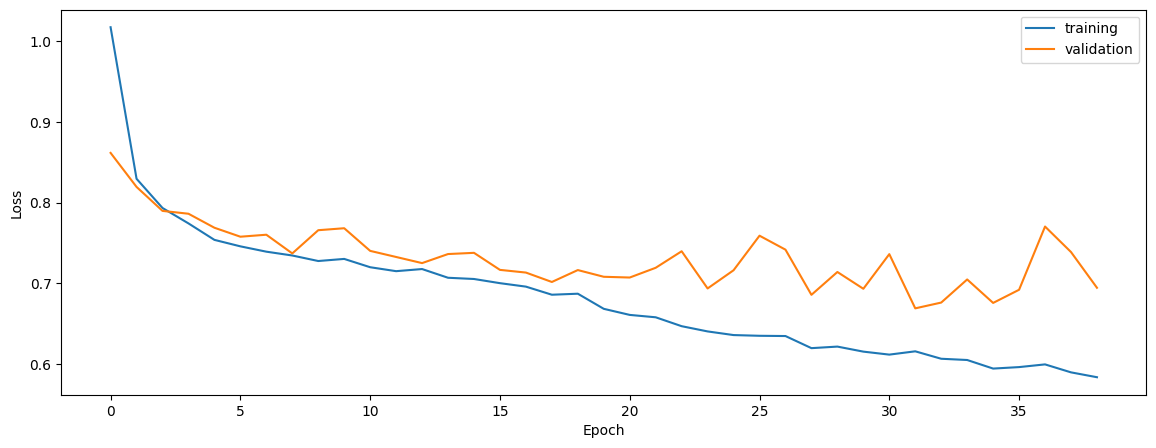

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7443775680712558


0.7149448482077638


0.7276148465194826


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.713009511723632


0.7200852712522523


0.7610643025785844


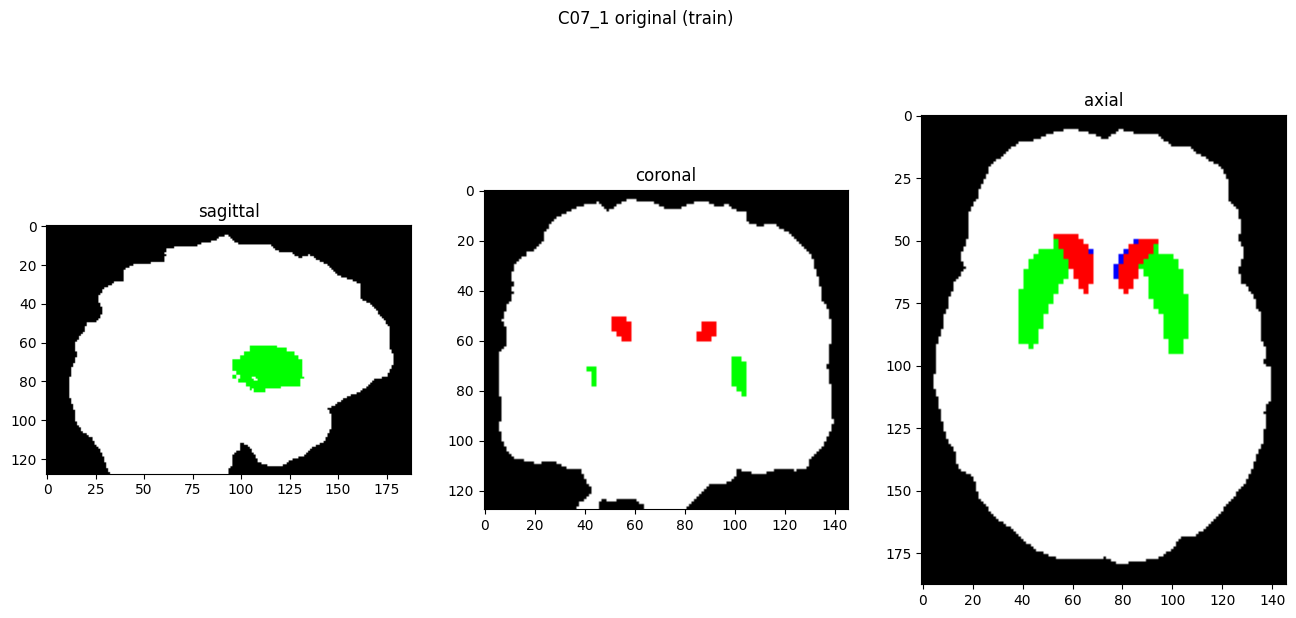

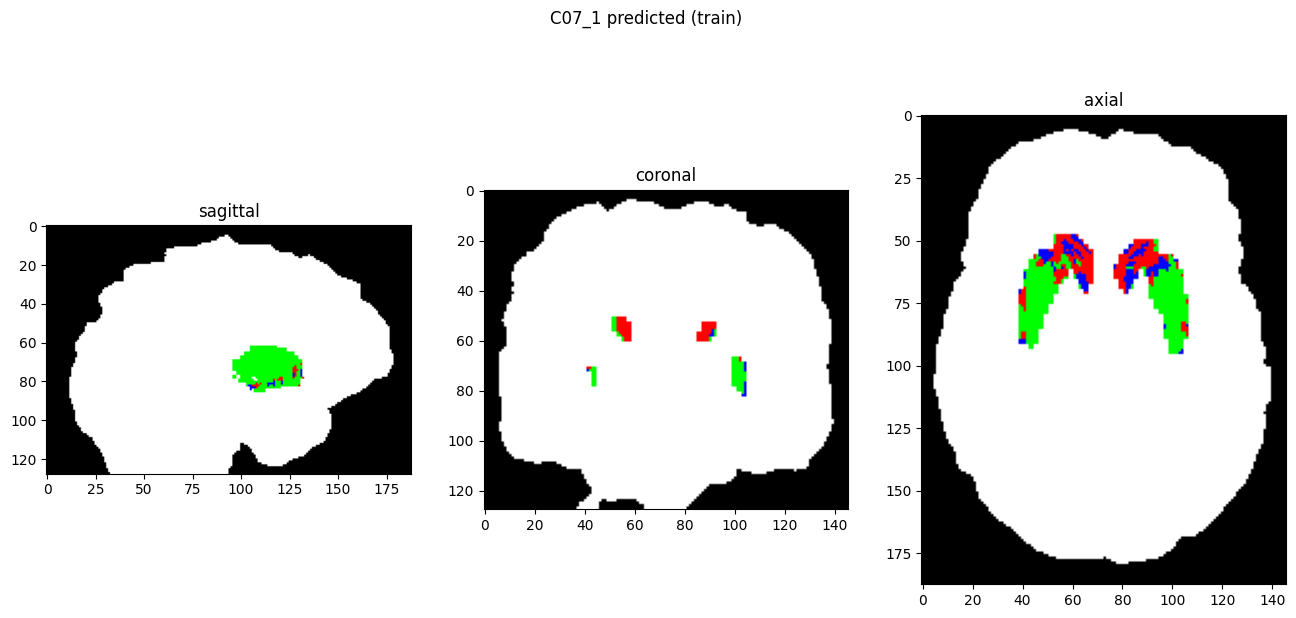

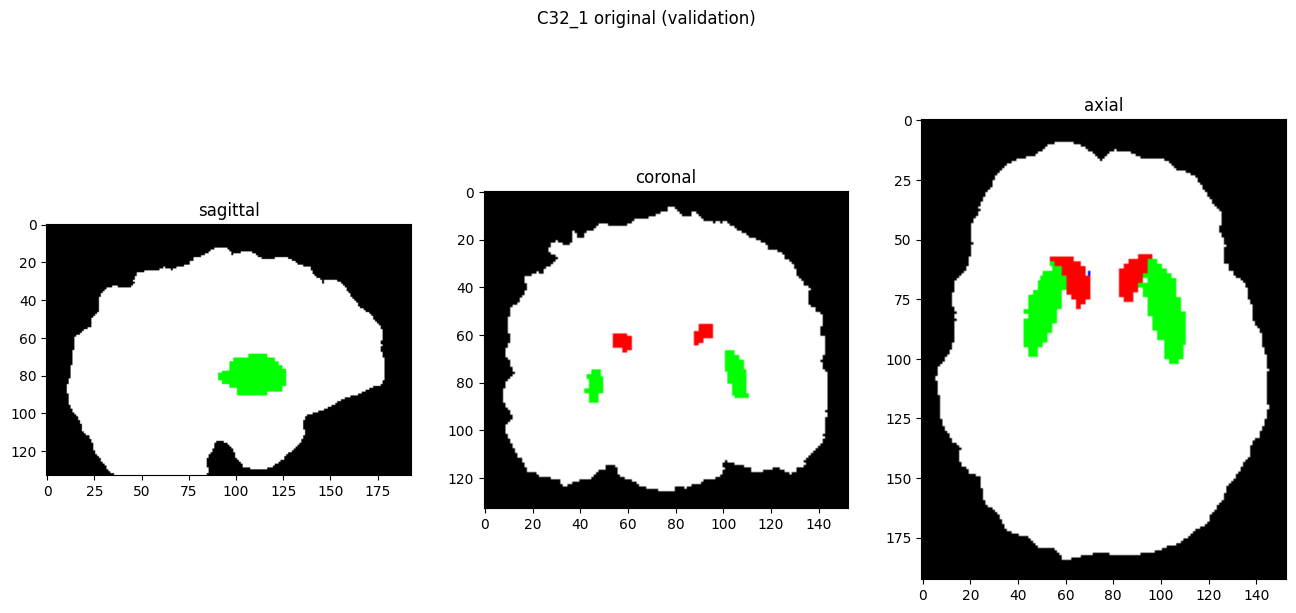

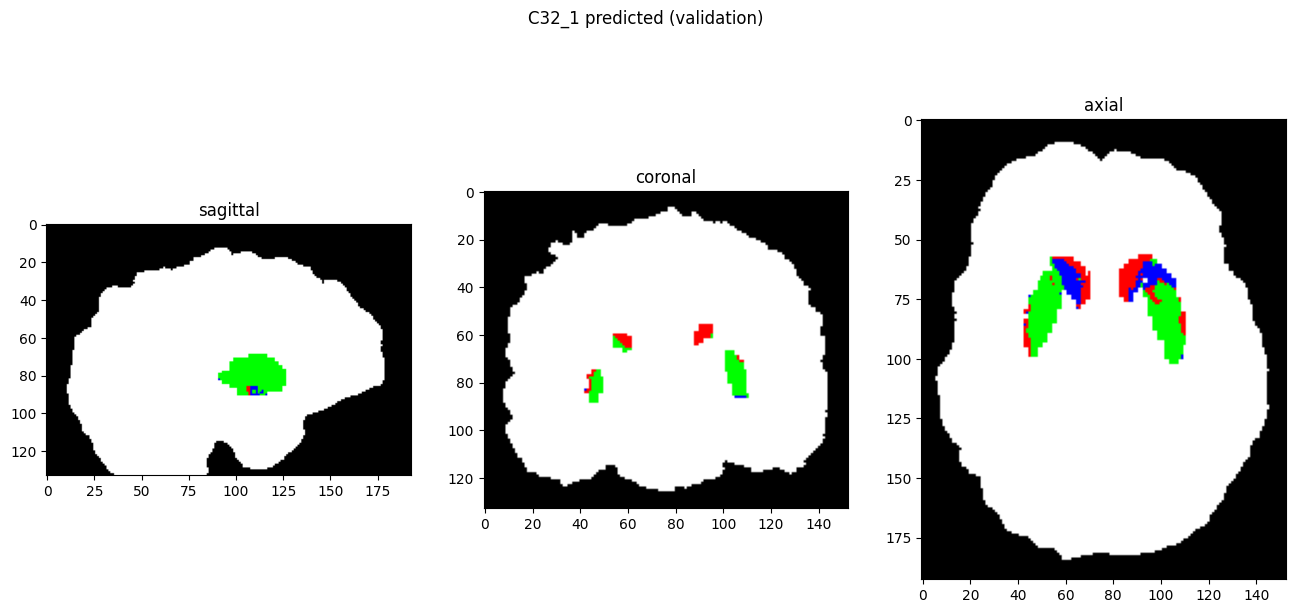

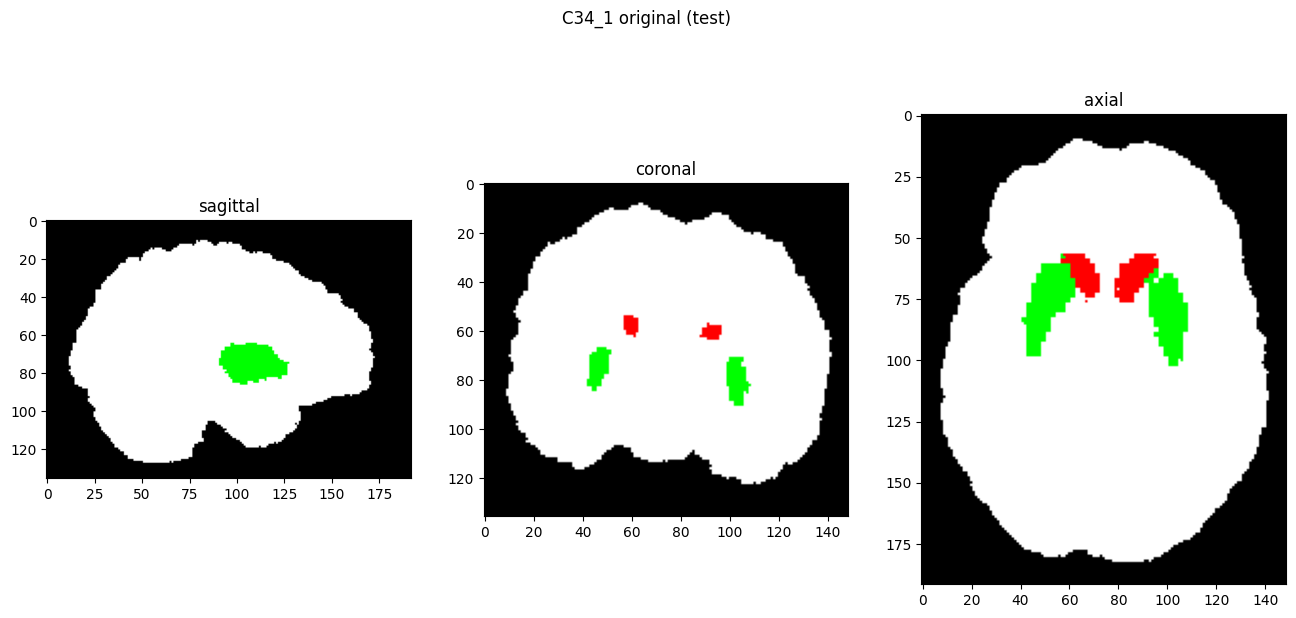

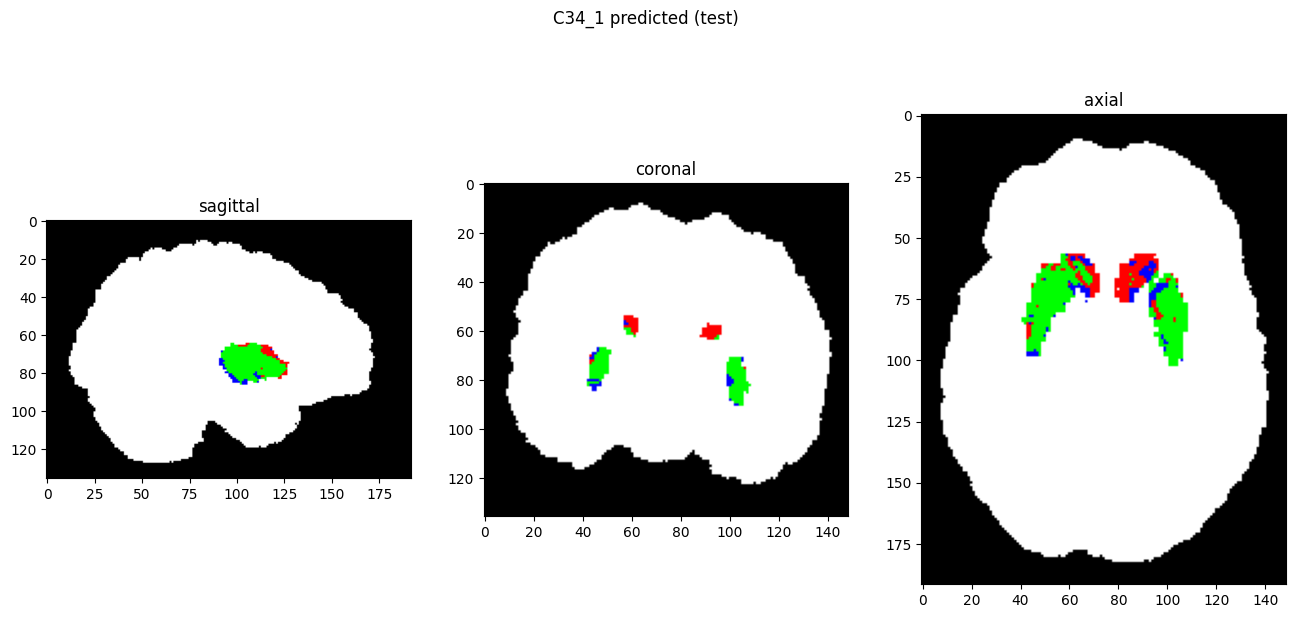

In [9]:
showResults(model, gen, threshold=0)